In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from importlib import reload as mreload
import utils
import learn
import yfinance as yf


We load hourly bitcoin data. Use the get_data.py module to download the dataset:

```sh
python get_data.py
```

In [3]:
mreload(utils)

df = pd.read_csv("data/BTCUSDT_1h_1_Jan_2023_23_May_2025.csv")

df["time"] = pd.to_datetime(df["timestamp"])

df["log_ret"] = np.log(df["close"]).diff()

df = utils.add_rsis(df, np.arange(2, 24 * 3 + 1))
df = utils.add_mas(df, np.arange(2, 24 * 3 + 1))
df = df.dropna().reset_index(drop=True)

df["clog_ret"] = np.cumsum(df["log_ret"])

df.index = df["time"].values


/home/mdm/coding/fintech/model_dev/learn/utils.py:129: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"means_{window_length}"] = df["close"].rolling(window_length).mean()
/home/mdm/coding/fintech/model_dev/learn/utils.py:130: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"std_{window_length}"] = df["close"].rolling(window_length).std(ddof=1)
/home/mdm/coding/fintech/model_dev/learn/utils.py:129: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

We added RSI with various window lengths (2-24 hours) as random forests are not time aware. We apply PCA with n_components=4 before training to reduce the dimensionality of the data.

Next train the model on all data. This will overfit. Nevertheless, we will do this to explore how the model works. We set a prediction interval of N = 3 and set the target as the change in log return.

In [4]:
df

timestamp       open       high        low  \
2023-01-04 00:00:00  2023-01-04 00:00:00   16675.65   16677.15   16652.66   
2023-01-04 01:00:00  2023-01-04 01:00:00   16660.53   16737.23   16657.68   
2023-01-04 02:00:00  2023-01-04 02:00:00   16701.63   16754.52   16701.50   
2023-01-04 03:00:00  2023-01-04 03:00:00   16736.52   16877.65   16736.39   
2023-01-04 04:00:00  2023-01-04 04:00:00   16862.61   16910.98   16849.44   
...                                  ...        ...        ...        ...   
2025-05-22 11:00:00  2025-05-22 11:00:00  110805.23  111326.20  110500.00   
2025-05-22 12:00:00  2025-05-22 12:00:00  110981.98  111626.43  110804.72   
2025-05-22 13:00:00  2025-05-22 13:00:00  111608.69  111625.75  110904.00   
2025-05-22 14:00:00  2025-05-22 14:00:00  110914.49  111397.94  110550.00   
2025-05-22 15:00:00  2025-05-22 15:00:00  110897.89  110935.80  110832.00   

                         close       volume     close_time  \
2023-01-04 00:00:00   16660.53   4922.78018  1672793999999   
2023-01-04 01:00:00   16701.97   9492.81204  1672797599999   
2023-01-04 02:00:00   16736.52   9182.69030  1672801199999   
2023-01-04 03:00:00   16862.02  18306.29002  1672804799999   
2023-01-04 04:00:00   16860.50  10155.76424  1672808399999   
...                        ...          ...            ...   
2025-05-22 11:00:00  110981.97    965.26641  1747915199999   
2025-05-22 12:00:00  111608.69   1598.01131  1747918799999   
2025-05-22 13:00:00  110914.49   1601.31192  1747922399999   
2025-05-22 14:00:00  110897.90   1686.01739  1747925999999   
2025-05-22 15:00:00  110887.23     53.04589  1747929599999   

                     quote_asset_volume  number_of_trades  taker_buy_base_vol  \
2023-01-04 00:00:00        8.204550e+07            167247          2453.25459   
2023-01-04 01:00:00        1.585720e+08            283396          4797.98717   
2023-01-04 02:00:00        1.536161e+08            268479          4757.49231   
2023-01-04 03:00:00        3.078242e+08            394599          9276.16324   
2023-01-04 04:00:00        1.713579e+08            282743          5173.10500   
...                                 ...               ...                 ...   
2025-05-22 11:00:00        1.069986e+08            171443           545.63901   
2025-05-22 12:00:00        1.778608e+08            242095           890.22119   
2025-05-22 13:00:00        1.781496e+08            322646           731.53656   
2025-05-22 14:00:00        1.870688e+08            371627           881.25510   
2025-05-22 15:00:00        5.882253e+06              7208            30.74278   

                     ...       std_68       means_69       std_69  \
2023-01-04 00:00:00  ...    68.972598   16651.935797    70.283550   
2023-01-04 01:00:00  ...    67.520571   16654.546232    68.708225   
2023-01-04 02:00:00  ...    66.660182   16657.528986    67.713299   
2023-01-04 03:00:00  ...    69.051678   16662.198986    70.526953   
2023-01-04 04:00:00  ...    70.548830   16667.044058    72.501579   
...                  ...          ...            ...          ...   
2025-05-22 11:00:00  ...  2031.804038  107162.432319  2037.587084   
2025-05-22 12:00:00  ...  2087.943584  107261.305942  2085.555851   
2025-05-22 13:00:00  ...  2120.042116  107341.857391  2117.984852   
2025-05-22 14:00:00  ...  2138.175943  107421.813188  2146.808979   
2025-05-22 15:00:00  ...  2164.339372  107510.338551  2162.111744   

                          means_70       std_70       means_71       std_71  \
2023-01-04 00:00:00   16650.237286    71.204861   16648.800000    71.724284   
2023-01-04 01:00:00   16652.650571    70.028205   16650.965915    70.960523   
2023-01-04 02:00:00   16655.717286    68.908622   16653.831831    70.235067   
2023-01-04 03:00:00   16660.450286    71.526359   16658.622958    72.663691   
2023-01-04 04:00:00   16665.031857    73.917012   16663.267887    74.877195   
...                            ...          ...            ...          ...   
2025-0

In [5]:
df["timestamp"].iloc[0]

'2023-01-04 00:00:00'

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

mreload(learn)

features  = utils.get_features_matrix(df)

scaler = StandardScaler()
zsc_f = scaler.fit_transform(features)

zsc_f = pd.DataFrame(zsc_f, columns=features.columns)

N = 2

y_input = np.log(df["close"].shift(-N) / df["close"]) 

pca, model, y_pred, y = learn.train_rf(features, y_input, N)
signal, up_q, low_q = learn.generate_signals(y_pred, df, N, qmin=0.025, qmax=0.975)

df["signal"] = signal
df["signal"] = df["signal"].rolling(N).mean()


In [43]:
features.shape

(20871, 213)

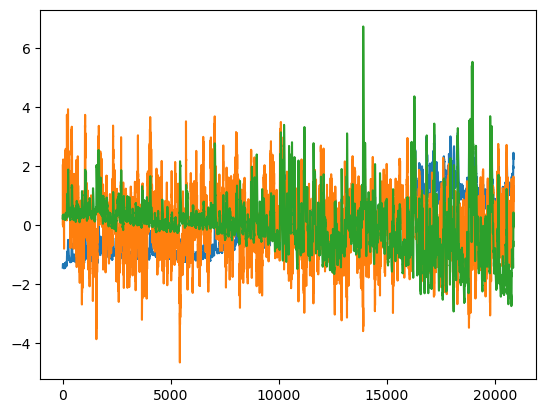

In [44]:


def norm_data(data):
    return (data - np.nanmin(data)) / (np.nanmax(data) - np.nanmin(data))



# N  = 6
yexp =  np.log(df["close"].shift(-N) / df["close"])

pca = PCA(n_components=5)



v1 = pca.fit_transform(zsc_f)

scaler = StandardScaler()
scaler.fit(v1)
v2 = scaler.transform(v1)


plt.plot((v2[:,0][:]))
plt.plot((v2[:,1][:]))
plt.plot((v2[:,2][:]))

# plt.plot(norm_data(df["log_ret"].values[:30]))
# plt.plot(norm_data(yexp.values[:30]))

In [45]:
"volume" in features.columns

False

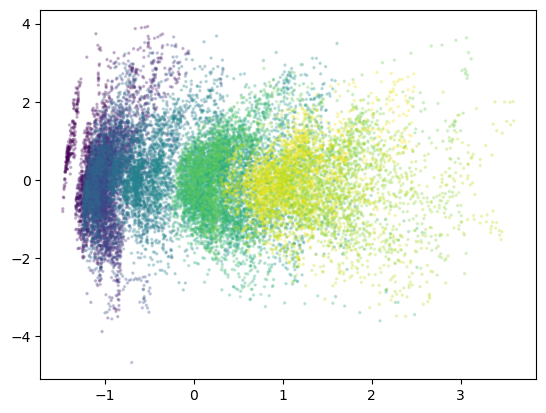

In [46]:
plt.scatter(v2[:,0][:], v2[:,1][:], c = (df["time"].values), s=2.3, alpha=0.23)


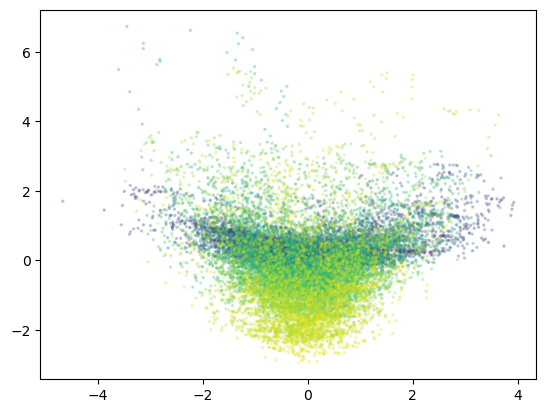

In [47]:
plt.scatter(v2[:,1][:], v2[:,2][:], c= np.log10(df["close"].values), s=2.3, alpha=0.23)

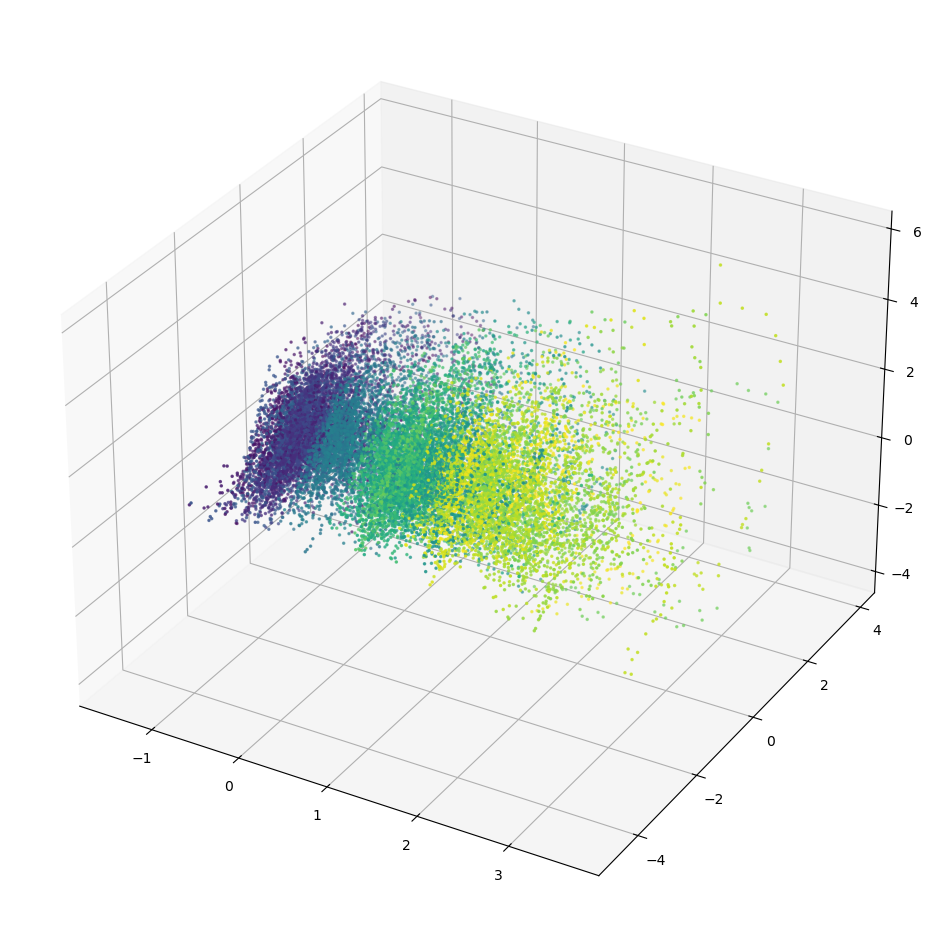

In [48]:

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(v2[:,0], v2[:,1], v2[:,3], c=df["time"].values, s=2.3)

/tmp/ipykernel_1173/2091373267.py:4: RuntimeWarning: divide by zero encountered in log
  ax.scatter(v2[:,0], v2[:,1], v2[:,2], c=np.log(df["volume"].values), s=2.3)


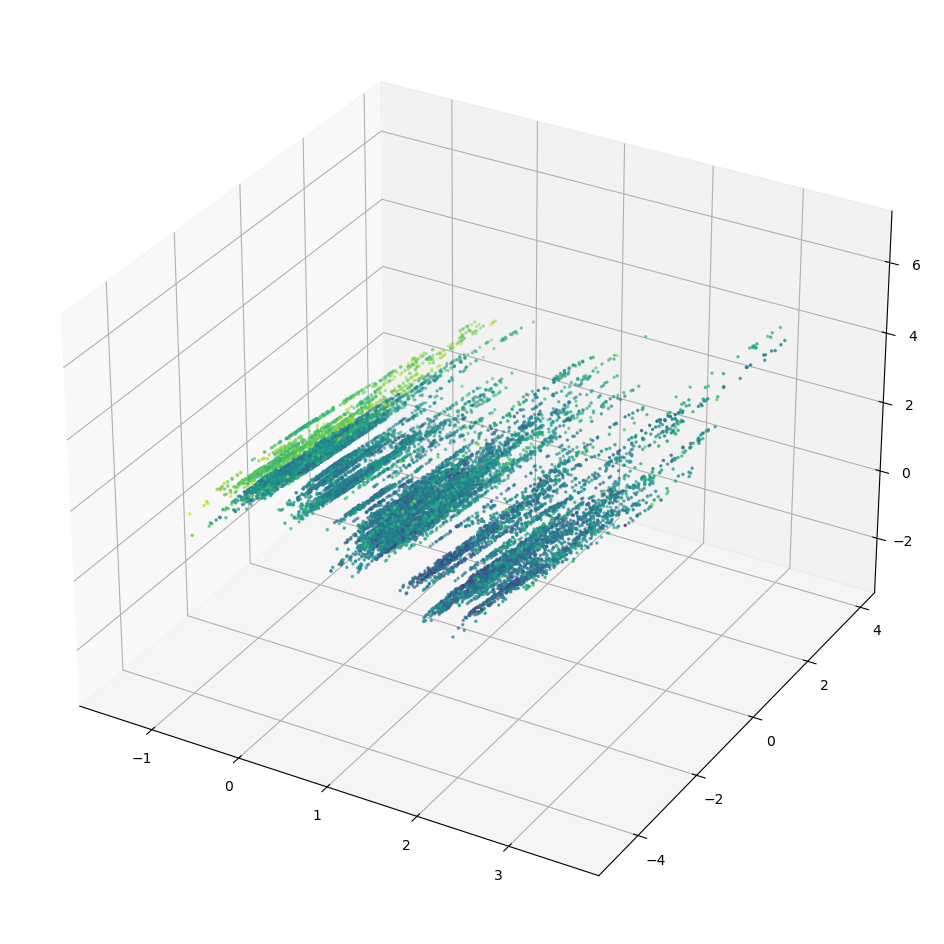

In [49]:

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(v2[:,0], v2[:,1], v2[:,2], c=np.log(df["volume"].values), s=2.3)

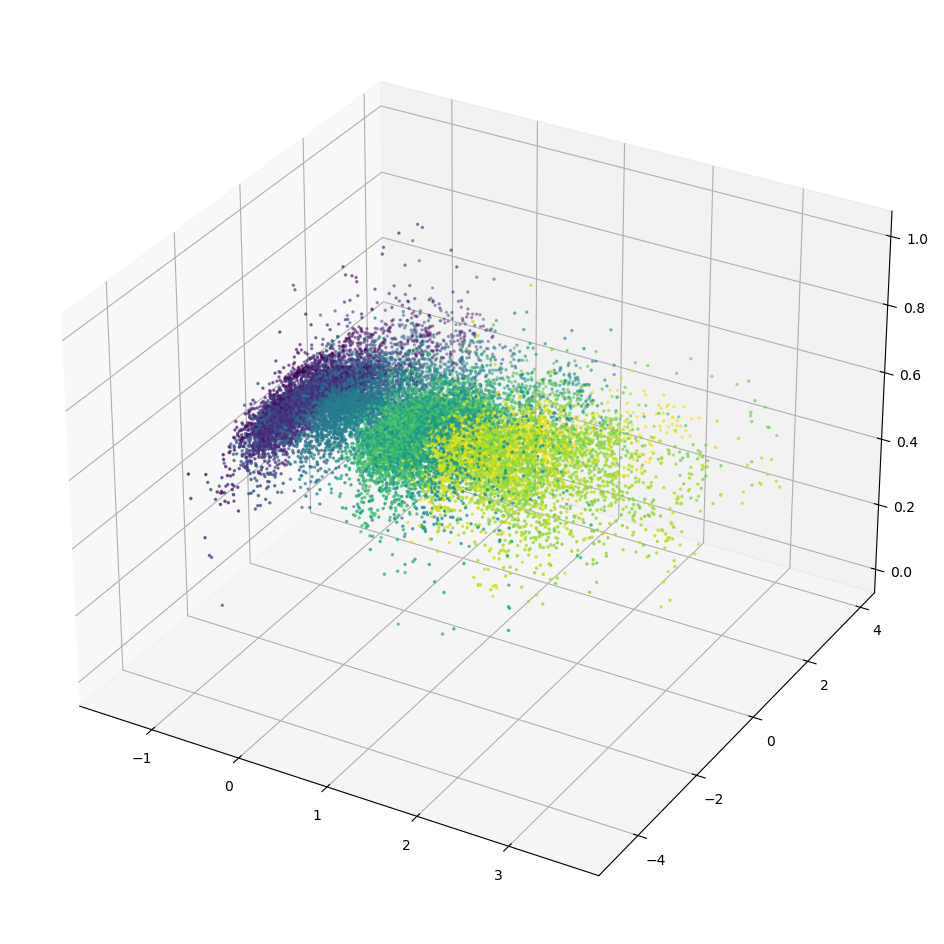

In [51]:

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(v2[:,0], v2[:,1], norm_data(y_input), c=(df["time"].values), s=2.3)

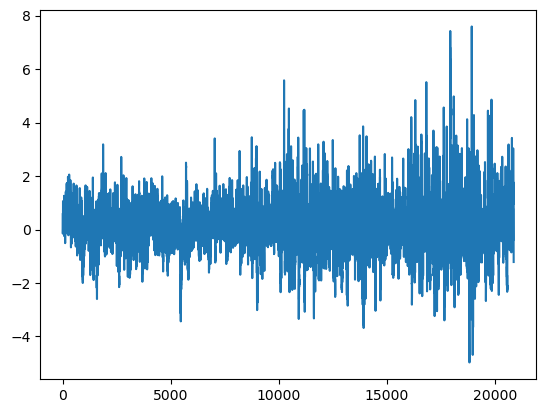

In [52]:
plt.plot((v2)[:,4])

In [53]:
np.cumsum(v2, axis=0)[:,0]

array([-1.44870888e+00, -2.87651871e+00, -4.28845069e+00, ...,
       -4.53711831e+00, -2.24859829e+00,  4.32827107e-11])

6.972313367048465e-17


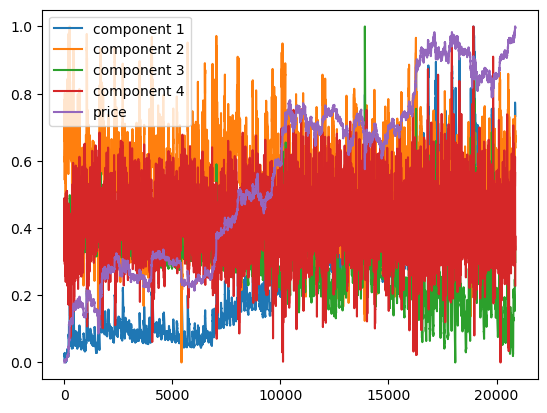

In [54]:
c1 = np.cumsum(v2[:,0], axis=0)
c2 = np.cumsum(v2[:,1], axis=0)

from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()
c1 = minmax.fit_transform(v2)



plt.plot(c1[:,0], label="component 1")
plt.plot(c1[:,1], label="component 2")
plt.plot(c1[:,2], label="component 3")
plt.plot(c1[:,3], label="component 4")
plt.plot(norm_data(np.cumsum(df["log_ret"]).values)[:], label="price")
# plt.plot(norm_data(np.cumsum(yexp.values)), label="price")
plt.legend()
print(v1.mean())

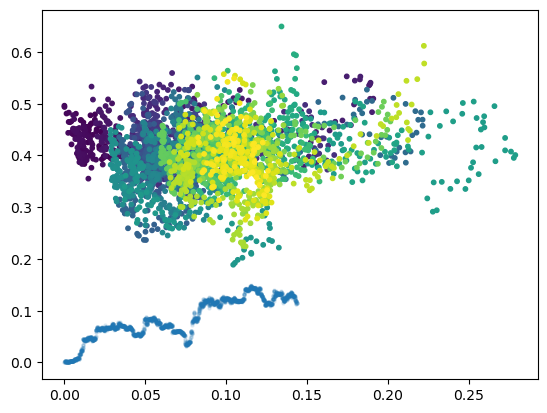

In [55]:
step = 3 * 1000
plt.scatter(c1[:,0][:step], c1[:,4][:step], c=(df["time"].values[:step]), s=10)
plt.scatter(norm_data(np.arange(df["close"].size))[:step], norm_data(df["close"])[:step], s=5, alpha=0.1)

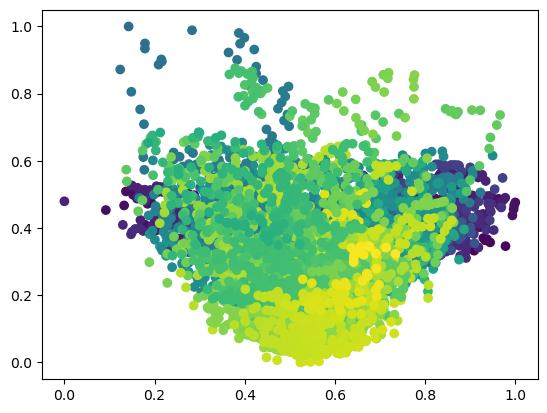

In [56]:
plt.scatter(c1[:,1], c1[:,2], c=df["close"].values)


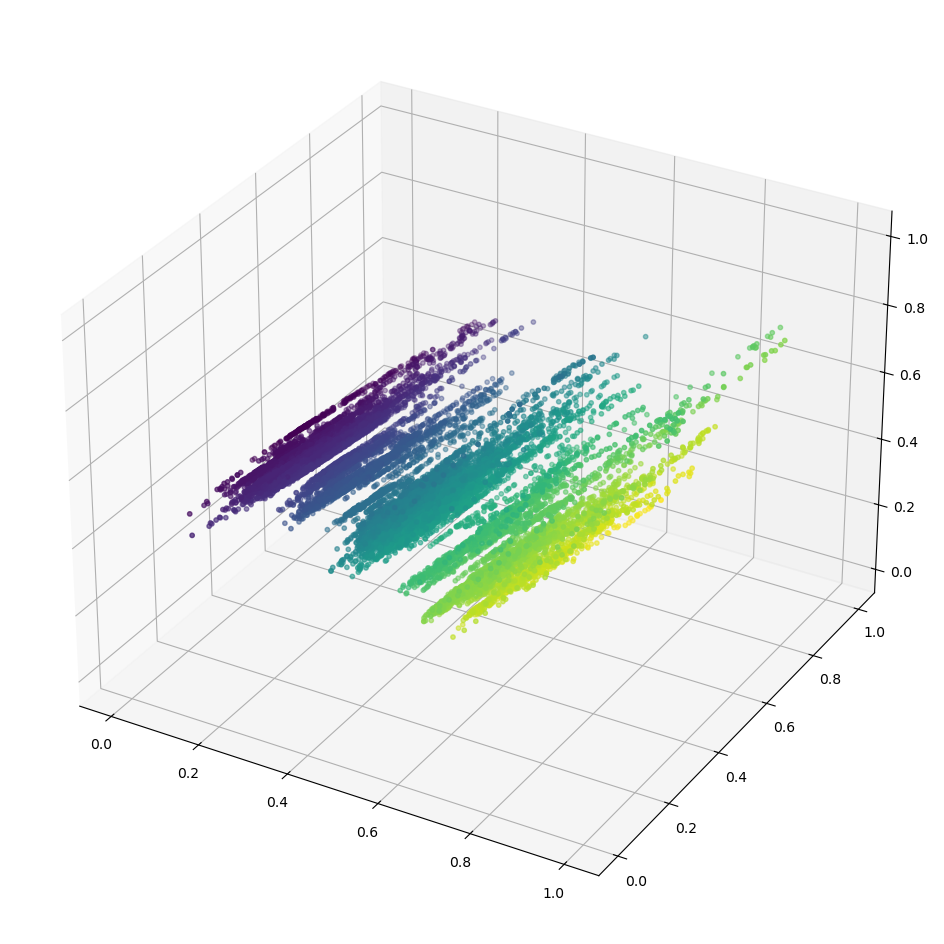

In [57]:

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(c1[:,0], c1[:,1], c1[:,2], c=(df["close"].values), s=10)

In [58]:
# 1    0.3  0.1
# 0.3  1    0.5
# 0.1  0.5  1  
#
#
#

In [59]:

# c1 = a1* f1 + a2*f2 + ... + an * fn

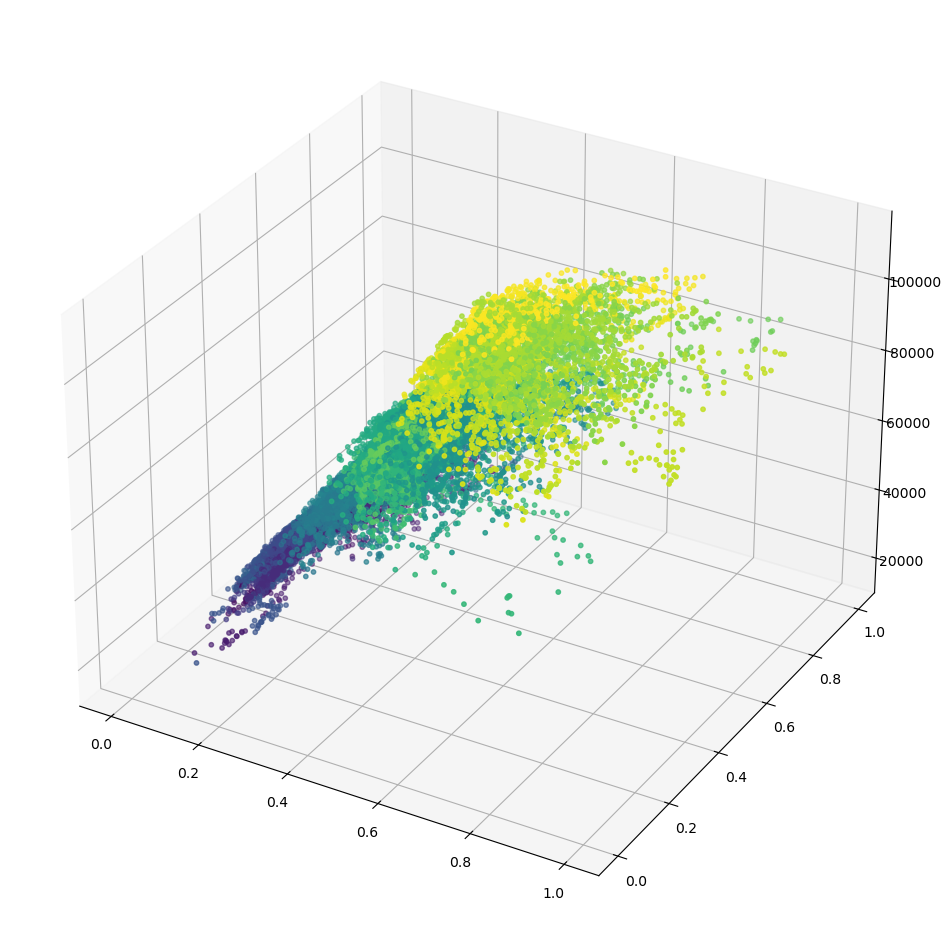

In [60]:

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(c1[:,0], c1[:,1], (df["close"]), c=(df["time"].values), s=10)

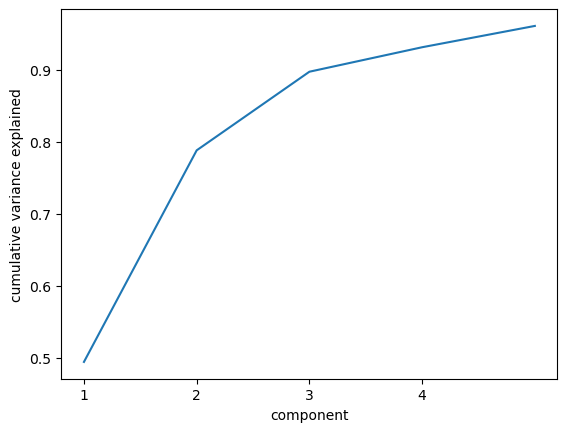

In [61]:
plt.plot(np.arange(pca.explained_variance_ratio_.size)+1, np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("component")
plt.ylabel("cumulative variance explained")
plt.xticks(np.arange(1,5));

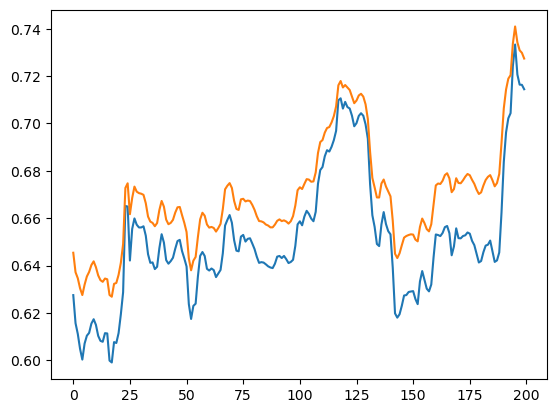

In [62]:
plt.plot(np.cumsum(y.values)[500:700])
plt.plot(np.cumsum(y_pred)[500:700])

We can see that the majority of variance is explained by the first four components. The fact that the first principal components explains 84% of all variance suggests that some extra preprocessing could be done.

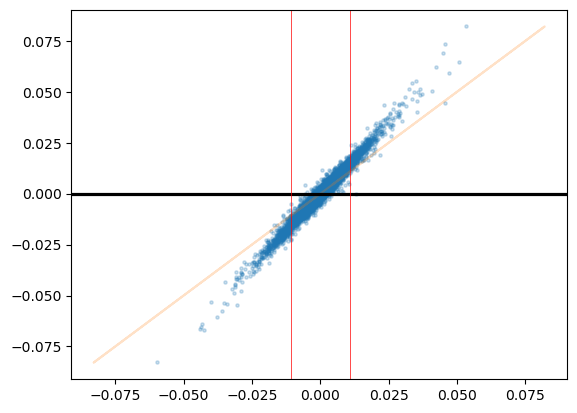

In [63]:
plt.plot(y_pred, y, "o", ms=2.3, alpha=0.23)
plt.plot(y, y, "-", ms=2.3, alpha=0.23)
plt.axhline(y=0, color="k", lw=2.3)
for q in [low_q, up_q]:
    plt.axvline(x=q, color="r", lw=0.5)

We can see that the in sample performance is amazing. The model guesses the change in log price very accurately. 

* long position if model prediction above 0.95 quantile
* short position if model prediction below 0.05 quantile
* We apply a moving average with window of N - this is a fractional signal that allows us to rebalance when new information comes in.

With this in mind, let us conduct a simple backtest to check the model performance

profit factor: 15.210833577291359, sharpe annual: 15.751415886380913


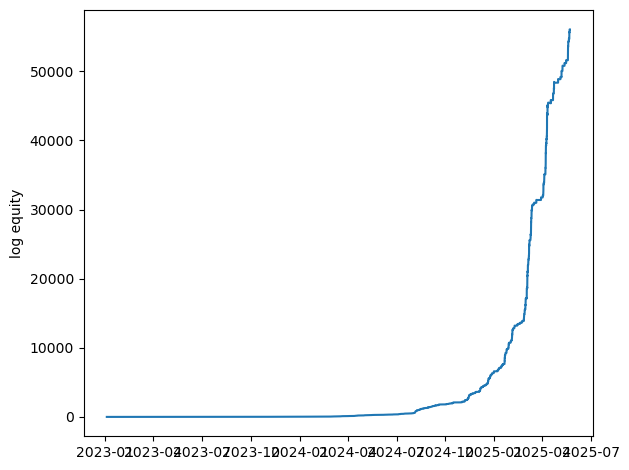

In [66]:

strat_ret, pr, sharpe = utils.compute_returns(df)
df["strat_return"] = strat_ret


plt.plot(df["time"], np.exp(np.nancumsum(df["strat_return"])))
plt.ylabel("log equity")
plt.tight_layout()


print(f"profit factor: {pr}, sharpe annual: { np.nanmean(strat_ret) * 8760 / (np.nanstd(strat_ret) * np.sqrt(8760)) }")


We can see that the strategy return is exceptionally good.This is because these are in sample predictions. Let us now perform walk-forward validation in order to  have a more realistic output of model performance. We will plot the first 5 out of sample predictions to visualise what is going on.

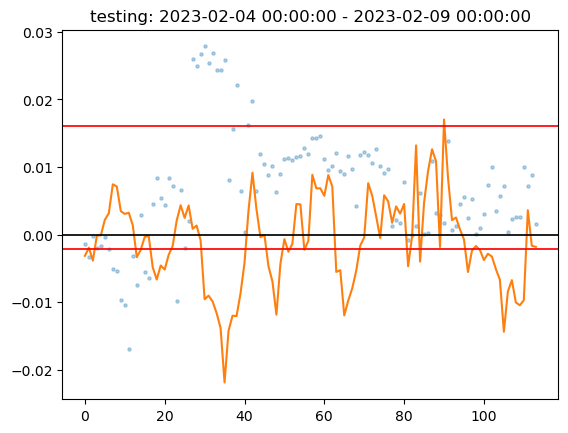

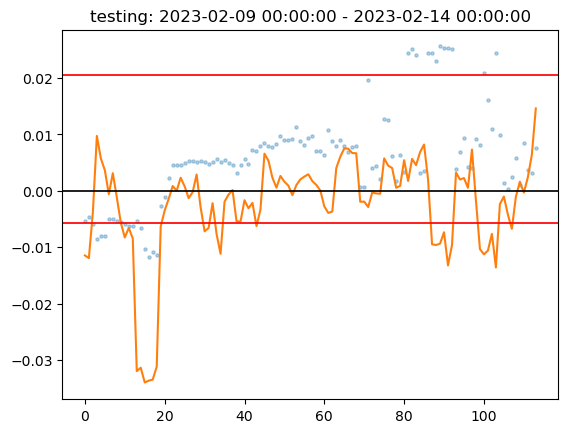

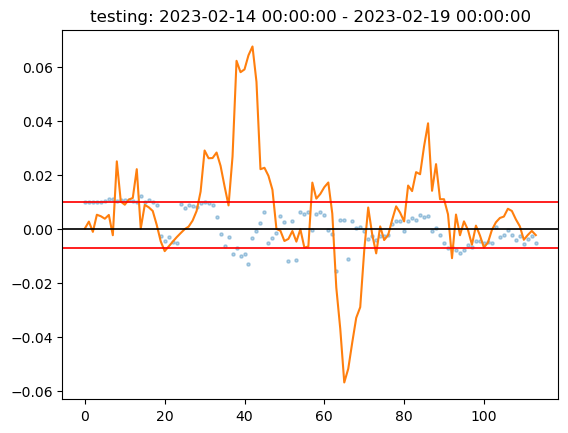

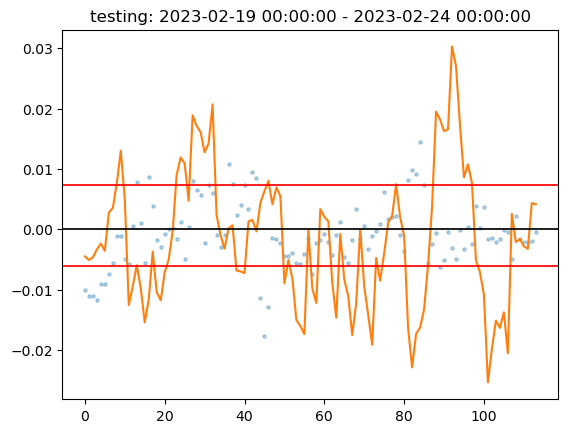

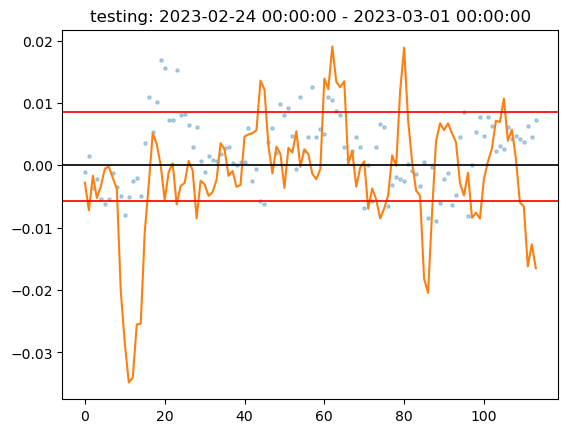

In [75]:
mreload(learn)

train_period = pd.DateOffset(months=1)
test_period = pd.DateOffset(days=5)

final_model, results_list, ygts, df_trading = learn.walk_forward(df, train_period, test_period, npca=3, N=6, qmin=0.1, qmax=0.9, plot=True)


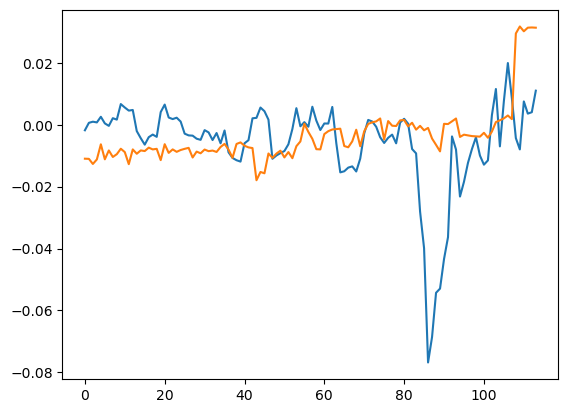

In [79]:
view=6
plt.plot(ygts[view].values[:400])
plt.plot(results_list[view][:400])

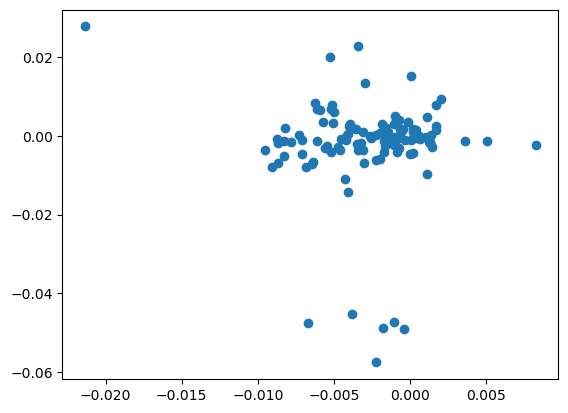

In [70]:
plt.plot(results_list[view][:1000], ygts[view].values[:1000], "o")


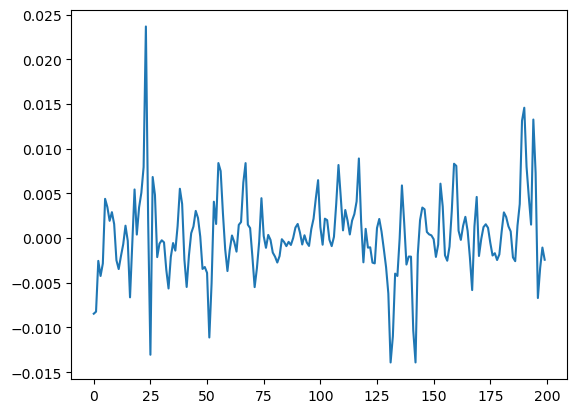

In [80]:
plt.plot()
plt.plot((y_pred)[500:700])

without costs:
profit factor: 1.1747523786588405, sharpe: 0.028813639404512172, sharpe ann: 2.696875885920882
with costs:
profit factor: 1.0376836579704842, sharpe: 0.006706247723040078, sharpe ann: 0.6276859897971229


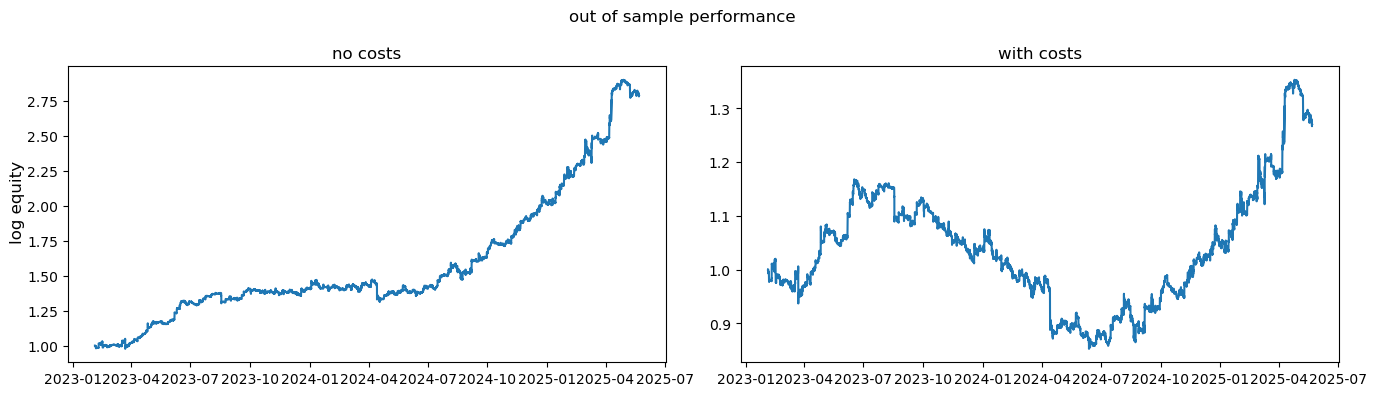

In [81]:
s  = df_trading["signal"]
# df_trading["signal"] = s * dftr["signal"]
my_ret, pr, sharpe = utils.compute_returns(df_trading, cost=0.00)

my_ret_fees, pr_fees, sharpe_fees = utils.compute_returns(df_trading, cost=0.00075)

fig, axs = plt.subplots(1,2, figsize=(14,4))

axs[0].plot(df_trading["time"], np.exp(np.nancumsum(my_ret)))
axs[0].set_title("no costs")

axs[1].plot(df_trading["time"], np.exp(np.nancumsum(my_ret_fees)))
axs[1].set_title("with costs")

fig.supylabel("log equity")
fig.suptitle("out of sample performance")
plt.tight_layout()

print("without costs:")
print(f"profit factor: {pr}, sharpe: {sharpe}, sharpe ann: { np.nanmean(my_ret) * 8760 / (np.nanstd(my_ret) * np.sqrt(8760)) }")
print("with costs:")
print(f"profit factor: {pr_fees}, sharpe: {sharpe_fees}, sharpe ann: { np.nanmean(my_ret_fees) * 8760 / (np.nanstd(my_ret_fees) * np.sqrt(8760)) }")

So our model still performs well out of sample. However, once we take costs into account, the equity curve sinks. Thus we need to take fees and slippage into account. Perhaps we can train a classifier to recognise scenarios when a trade is worth it.


## Developing a binary classification model using LSTM neural network


In [90]:
import compound
mreload(compound)


train_period = pd.DateOffset(months=12) #6 months
test_period = pd.DateOffset(months=2)
N= 72

chop_point = df.index.min() + pd.DateOffset(months=13)

dfchop = (df.index <= chop_point)
dfshort = df.copy()
dfshort = dfshort[dfchop]

# fm, rl, dftr = compound.walk_forward_c(df, train_period, test_period, npca=2, N=4, cost=0.23 *1e-2, qmin=0.025, qmax=0.975, plot=False)
fm, rl, raw_signals, unprocessed_signals, dftr = compound.walk_forward_c(dfshort, train_period, test_period, npca=3, N=N, cost=0.1 *1e-2, ntrain=200, plot=False, verbose=True, save_path="nn_lstm_model")

Training: 2023-01-04 00:00:00 to 2024-01-04 00:00:00...
tensor([3.9983], device='cuda:0', dtype=torch.float64)
Epoch 0, Loss: 1.2380
Epoch 100, Loss: 1.0289
Testing: 2024-01-04 00:00:00 to 2024-03-04 00:00:00
testing accuracy: 0.6309523809523809, testing loss: 1.3152687549591064
num real hits: 188, num predicted: 212
class 1 accuracy: 0.3584905660377358


without costs:
profit factor: 0.8940175733504923, sharpe: -0.0237293049501139, sharpe ann: -2.2224373384904323
with costs:
profit factor: 0.8775227547239638, sharpe: -0.02779880063042052, sharpe ann: -2.603577838296582


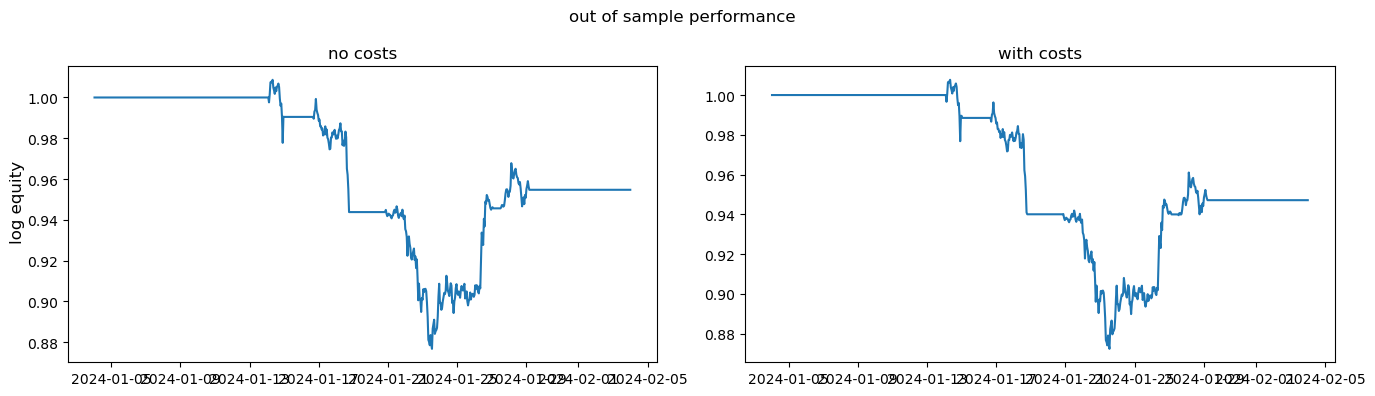

In [92]:
mreload(utils)
dftest = dftr.copy()

dftest["signal"] =  dftr["raw_signal"] #.rolling(N).mean().fillna(0)

# _sig = utils.suppress_consecutive_repeats(dftr["signal"])
# dftr["signal"] = utils.generate_positions(_sig, horizon=N)

my_ret, pr, sharpe, _ = utils.compute_returns_nn(dftr, cost=0.00)

my_ret_fees, pr_fees, sharpe_fees, ts = utils.compute_returns_nn(dftr, cost=0.001, thr=0.00)

fig, axs = plt.subplots(1,2, figsize=(14,4))

axs[0].plot(dftr["time"], np.exp(np.nancumsum(my_ret)))
axs[0].set_title("no costs")

axs[1].plot(dftr["time"], np.exp(np.nancumsum(my_ret_fees)))
axs[1].set_title("with costs")

fig.supylabel("log equity")
fig.suptitle("out of sample performance")
plt.tight_layout()


print("without costs:")
print(f"profit factor: {pr}, sharpe: {sharpe}, sharpe ann: { np.nanmean(my_ret) * 8760 / (np.nanstd(my_ret) * np.sqrt(8760)) }")
print("with costs:")
print(f"profit factor: {pr_fees}, sharpe: {sharpe_fees}, sharpe ann: { np.nanmean(my_ret_fees) * 8760 / (np.nanstd(my_ret_fees) * np.sqrt(8760)) }")


0.6458333333333334


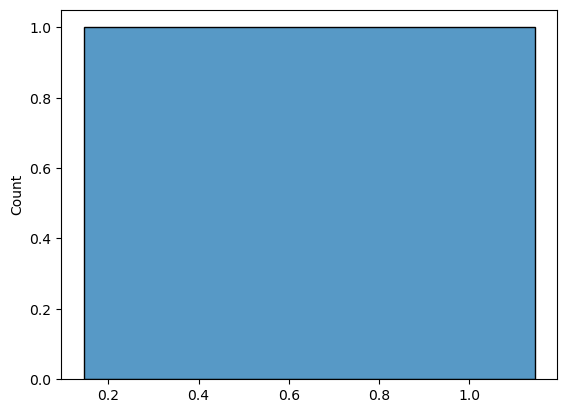

In [540]:
sns.histplot(rl)
print(np.median(rl))

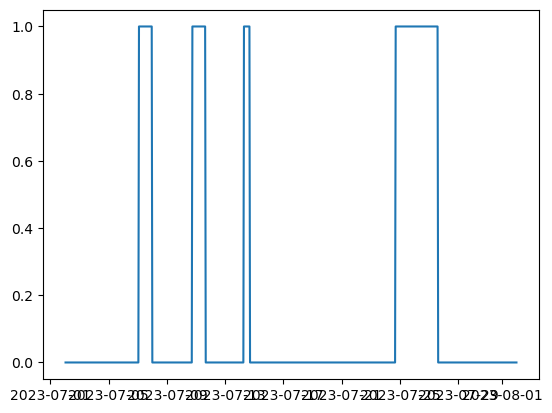

In [545]:
plt.plot(dftr["raw_signal"])

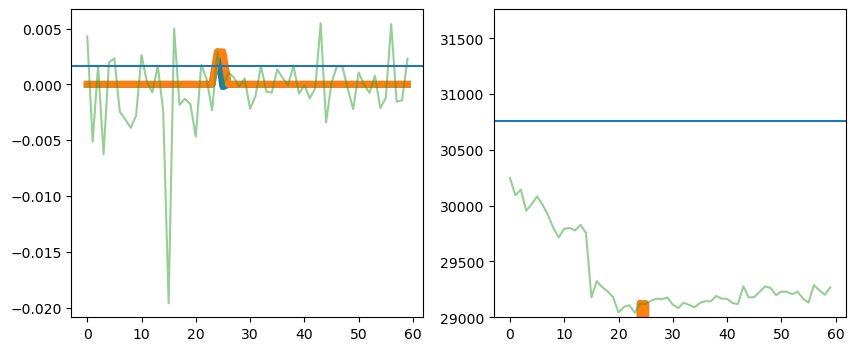

In [542]:


sig = dftr["raw_signal"].values.copy()

shiftval = -1
x = dftr["log_ret"].shift(shiftval).values.copy()
x2 = dftr["close"].shift(shiftval).values.copy()
x3 = dftr["close"].pct_change().shift(shiftval).values.copy() #try y = log(close.shift(-N)/close)


signal = sig.copy()
pct_change = dftr["close"].pct_change().shift(shiftval).values.copy() #try y = log(close.shift(-N)/close)
next_r = dftr["log_ret"].shift(shiftval).values.copy()


trade_signal = np.zeros_like(signal)
in_trade = False
entry_index = None

for i in range(1, len(signal)):
    if not in_trade and signal[i] == 1 and signal[i - 1] == 0:
        # Start trade
        in_trade = True
        trade_signal[i] = 1
    elif in_trade:
        if signal[i] == 0:
            # End of signal block
            in_trade = False
        elif pct_change[i] >= 0.005:
            # Exit due to threshold breach
            trade_signal[i] = 1
            in_trade = False
        else:
            # Continue trade
            trade_signal[i] = 1
   

cutoff1 = float(np.nanquantile(x3, 0.9))
cutoff2 = float(np.nanquantile(x2, 0.9))




trade_signal = ts.values.ravel()
st = 520
end = 580

fig, axs = plt.subplots(1,2, figsize=(10,4))

axs[0].plot((trade_signal*x3)[st:end], lw=5)

axs[0].plot(((trade_signal*x3)[st:end].max())*(trade_signal)[st:end], lw=5)
axs[0].plot(x[st:end], alpha =0.5)
# axs[0].ylim(29000)

axs[0].axhline(y=cutoff)


axs[1].plot((trade_signal*x2)[st:end], lw=5)
axs[1].plot(((trade_signal*x2)[st:end].max())*(trade_signal)[st:end], lw=5)
axs[1].plot(x2[st:end], alpha =0.5)
axs[1].set_ylim(29000)

axs[1].axhline(y=cutoff2)


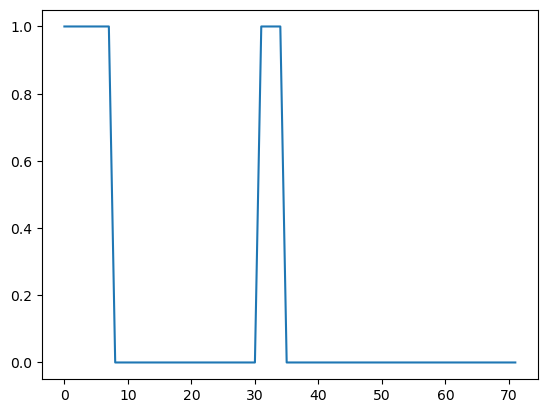

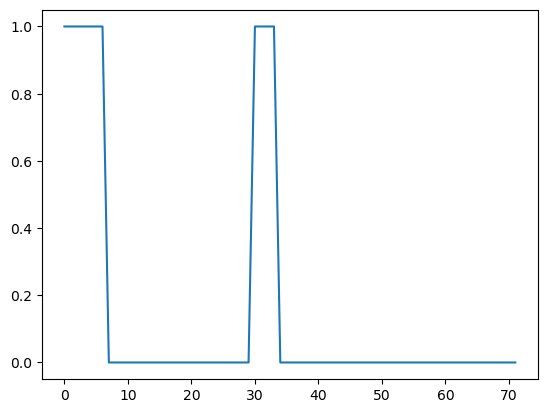

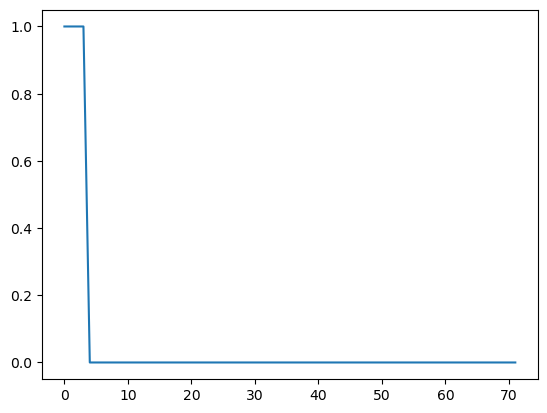

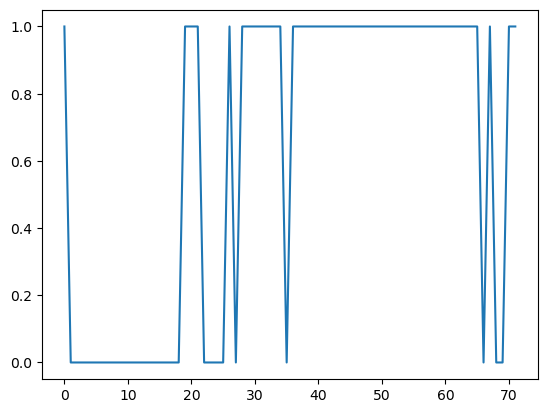

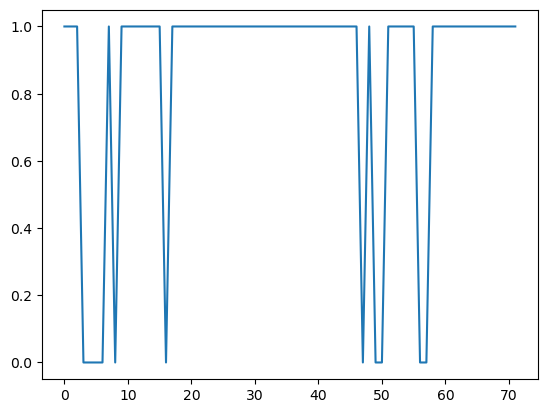

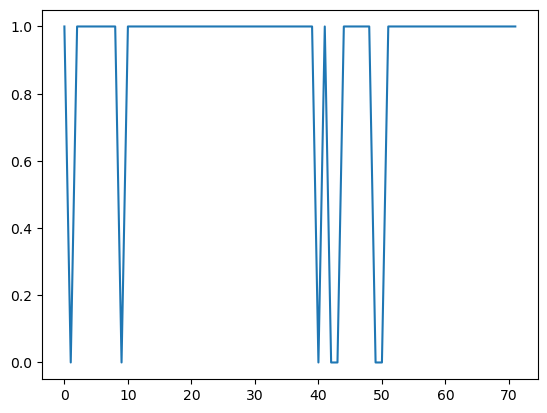

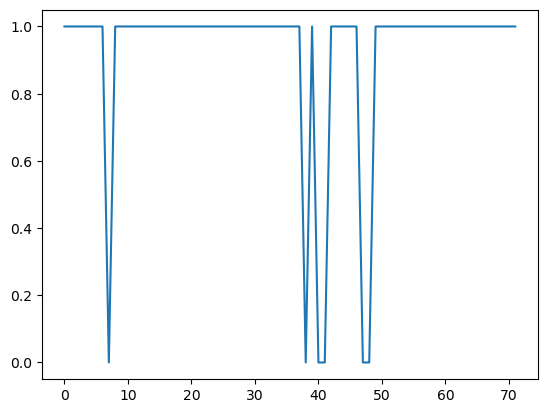

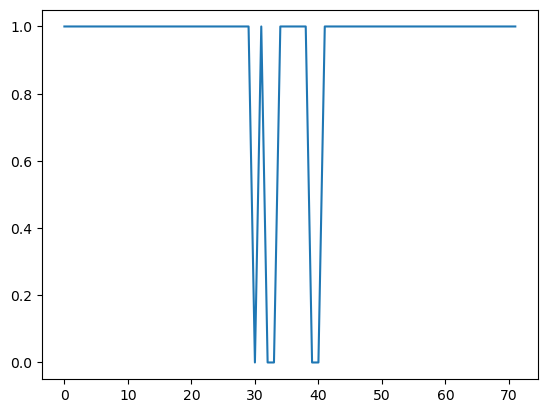

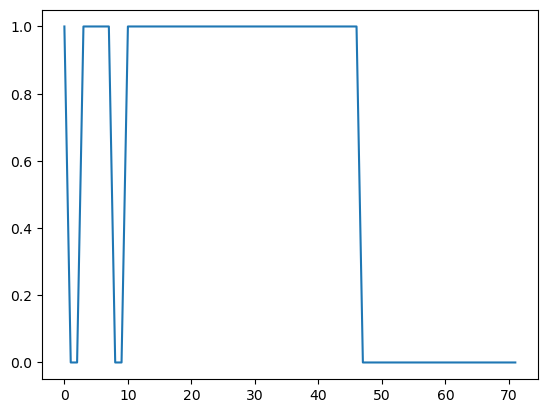

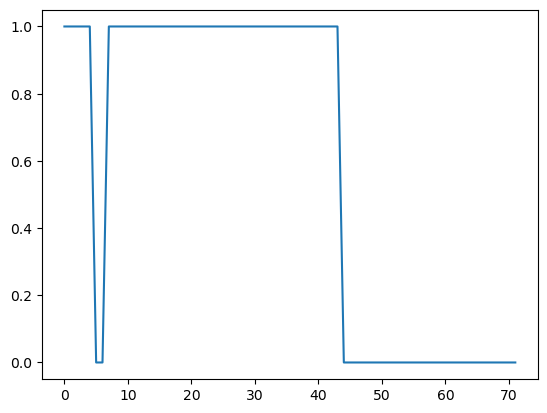

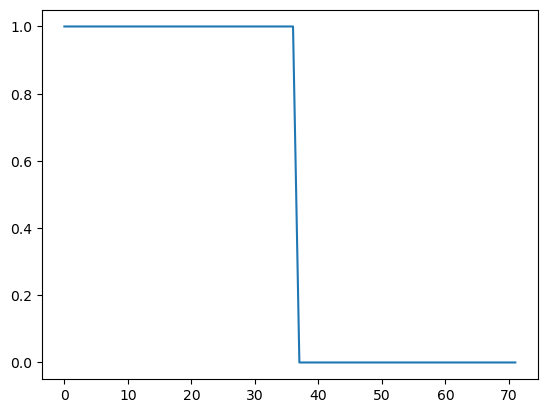

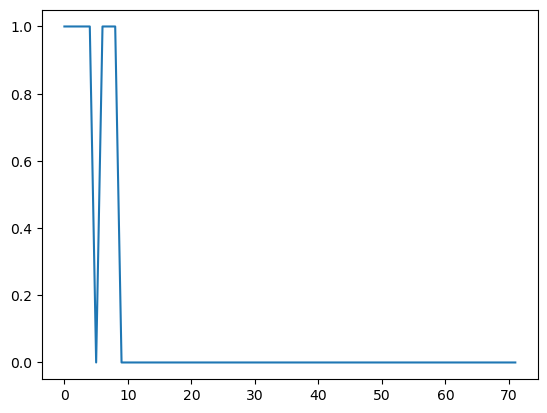

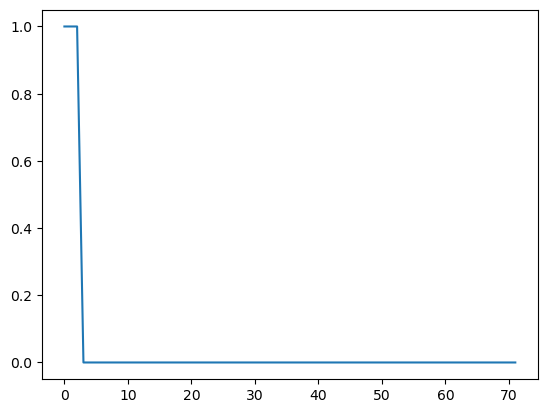

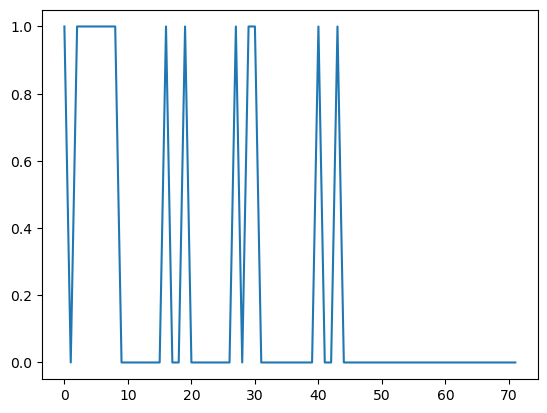

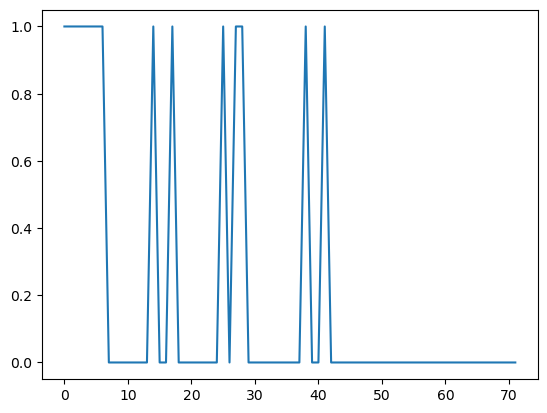

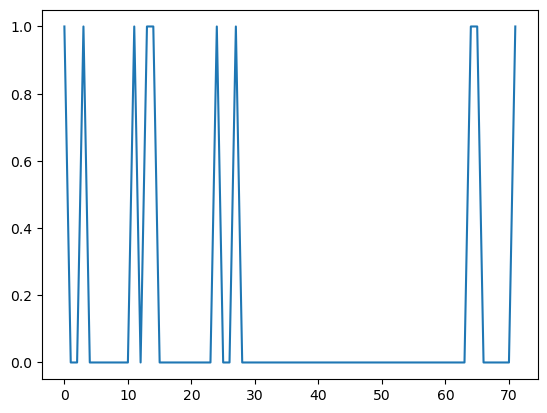

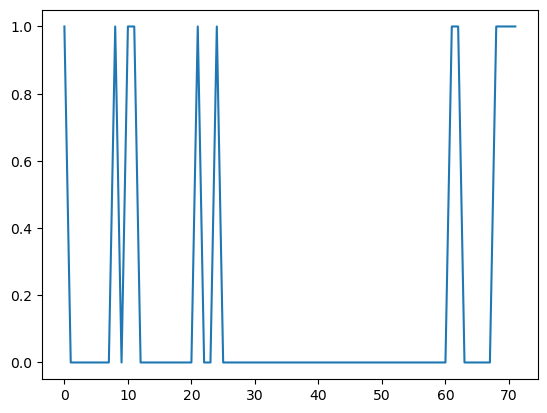

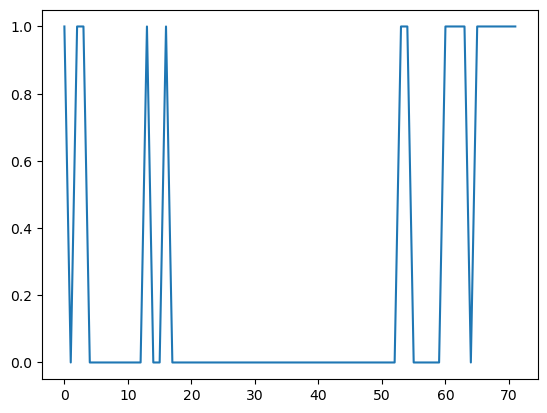

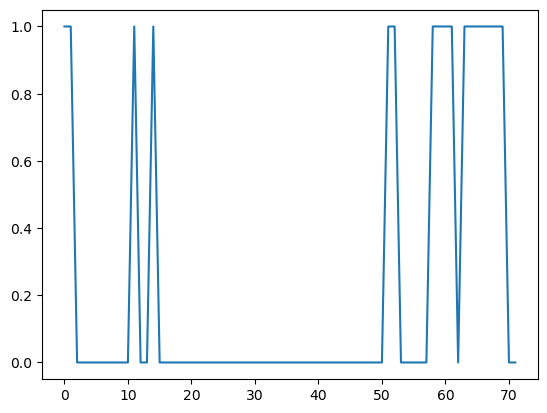

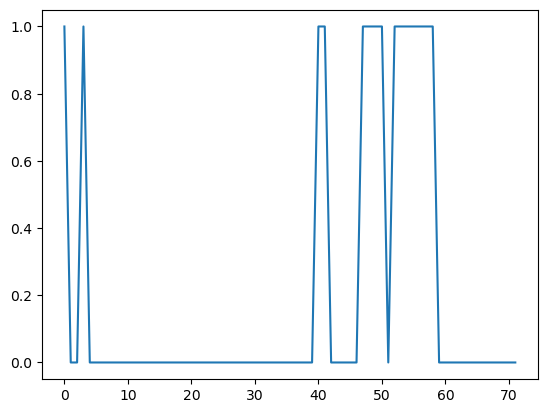

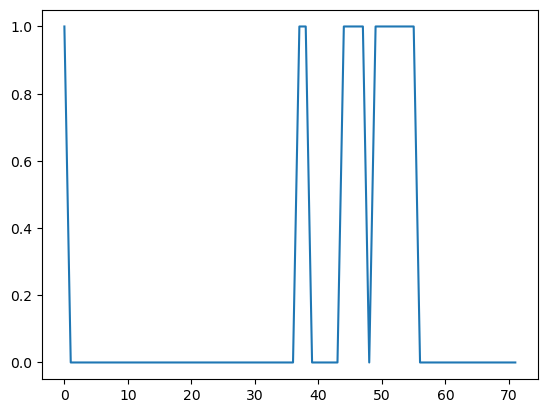

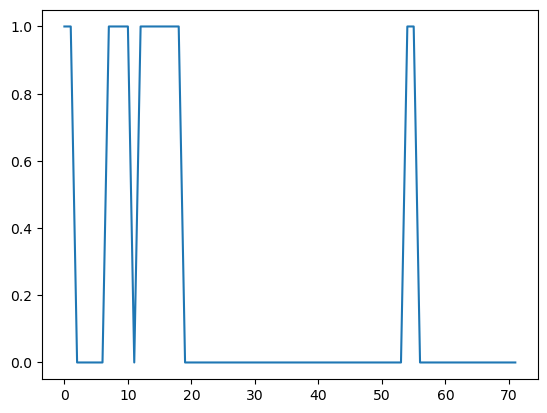

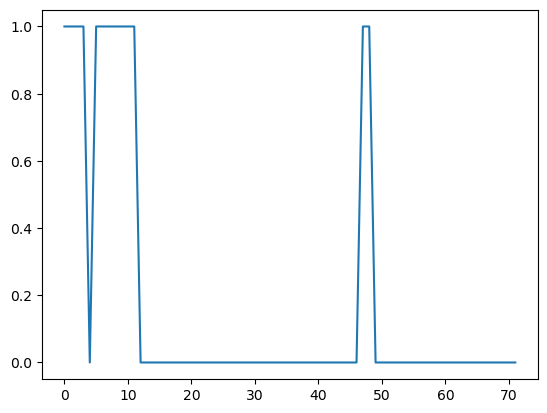

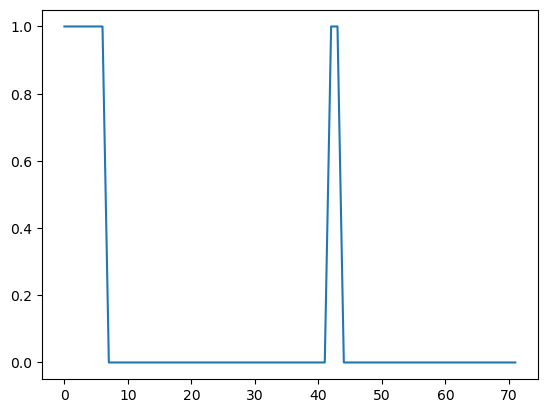

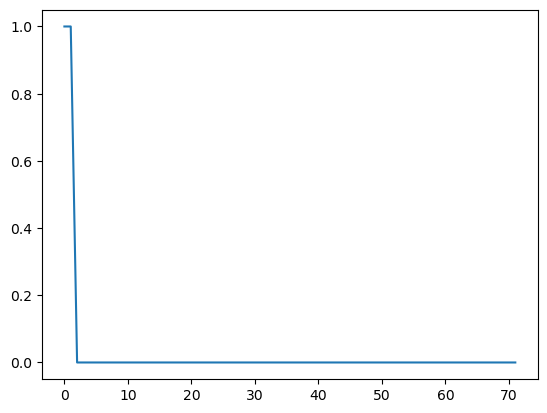

In [ ]:
y = np.log(dftr["close"].shift(-N) / dftr["close"])

q = np.nanquantile(y, 0.8)

tar = np.zeros_like(y)

fillargs = np.where(y>q)[0]

tar[fillargs] = 1


def get_blocks(signal:np.ndarray, N):

    block_idx = []
    for i in range(signal.size):
        
        if i > 1 :
            if signal[i] == 1 and signal[i-1] == 0:
                    block_idx.append(i)
        
        else:
             if signal[i] == 1:
                  block_idx.append(i)
    
    blocks = [signal[idx:idx+N] for idx in block_idx]

    return blocks




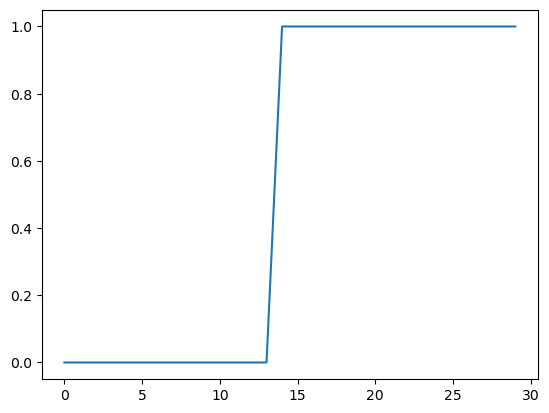

In [527]:
plt.plot(trade_signal[530:560])

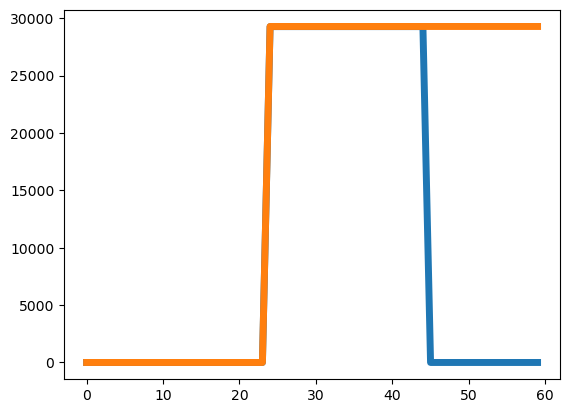

In [528]:
plt.plot(((trade_signal*x2)[st:end].max())*(trade_signal)[st:end], lw=5)
plt.plot(((sig*x2)[st:end].max())*(sig)[st:end], lw=5)

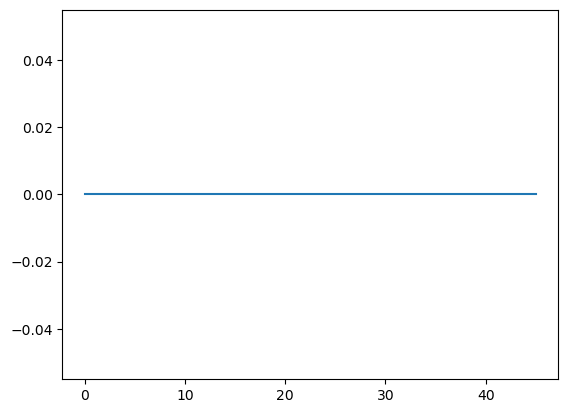

In [529]:
arr = (x3*sig)[154:200]
plt.plot(arr)

/tmp/ipykernel_1058/1724312797.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1,2, figsize=(10,4))


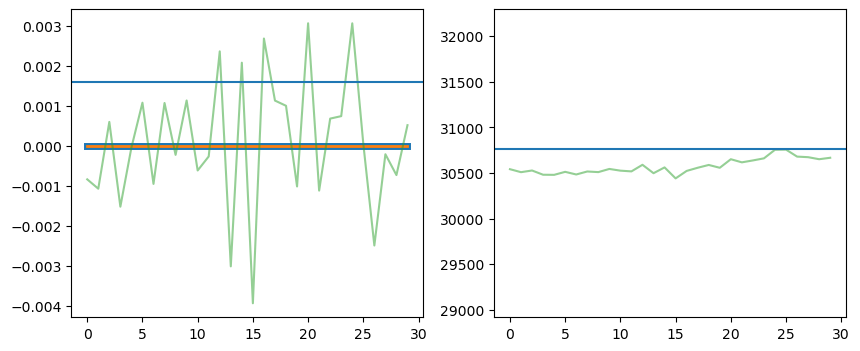

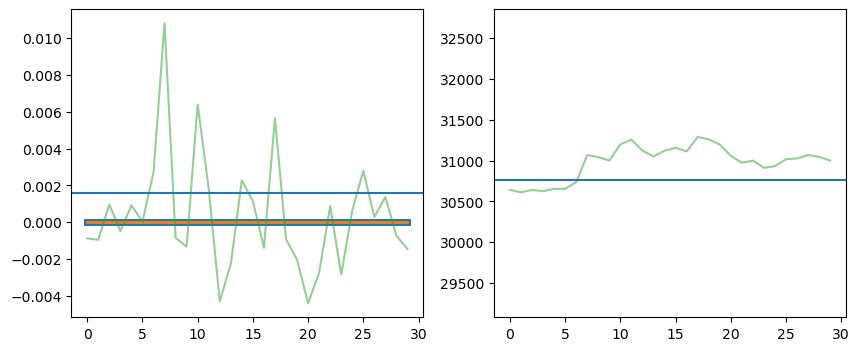

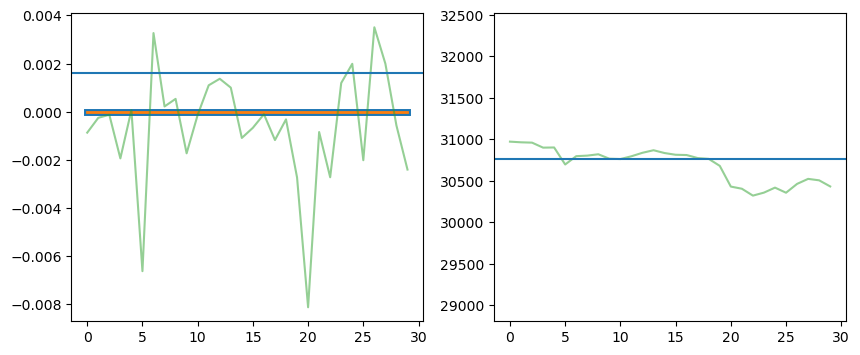

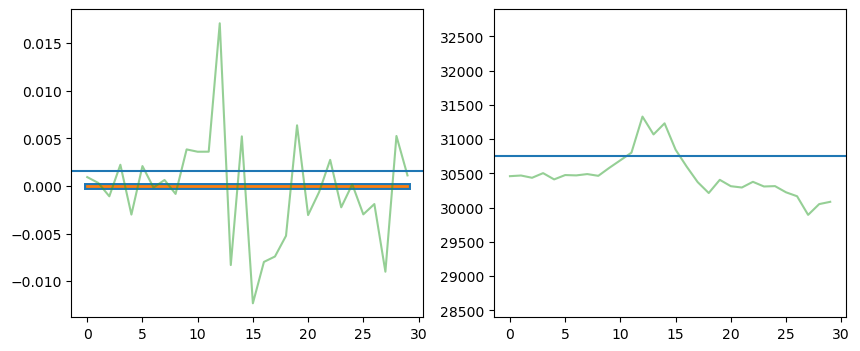

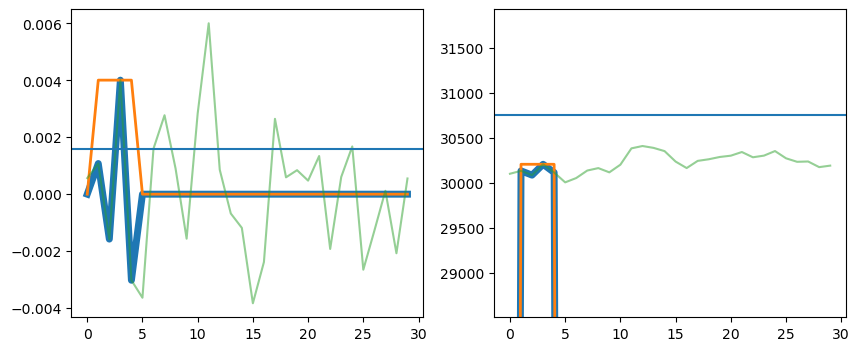

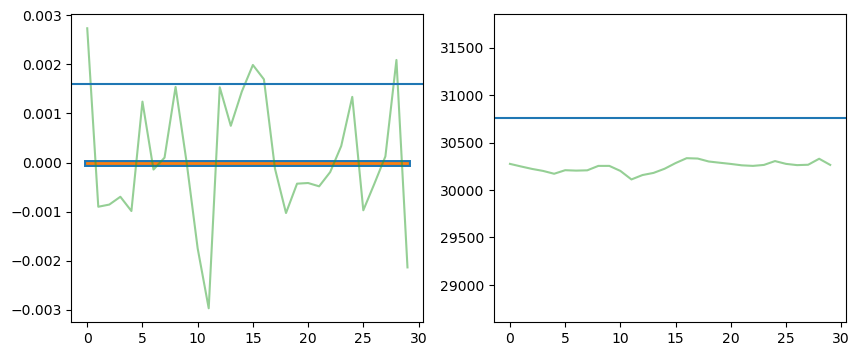

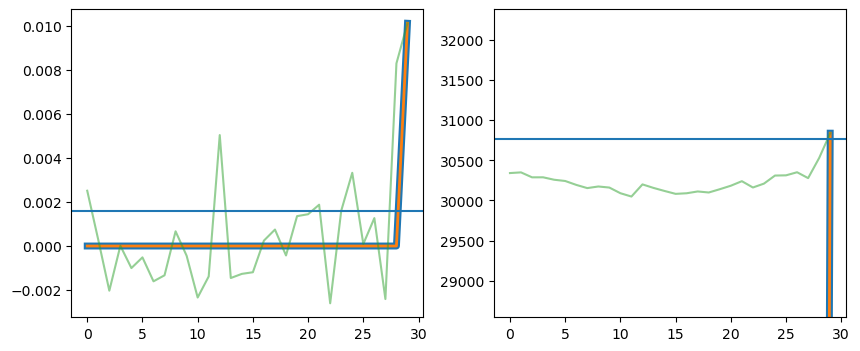

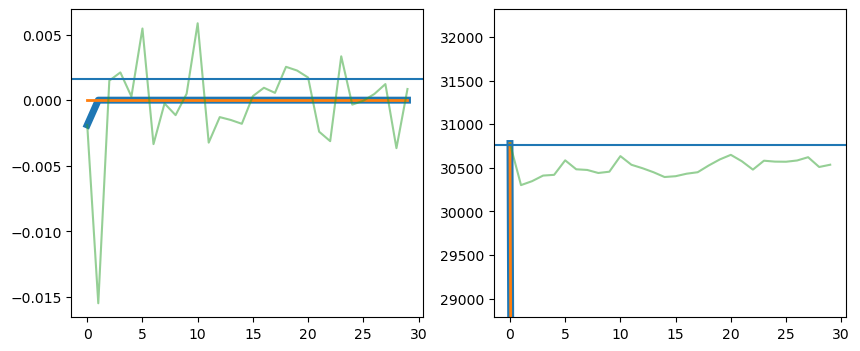

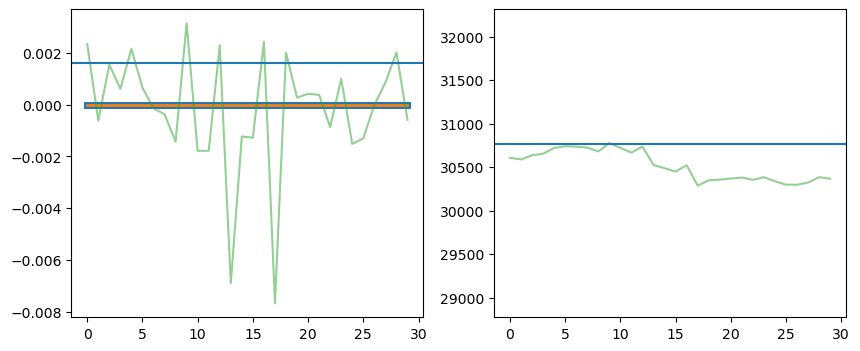

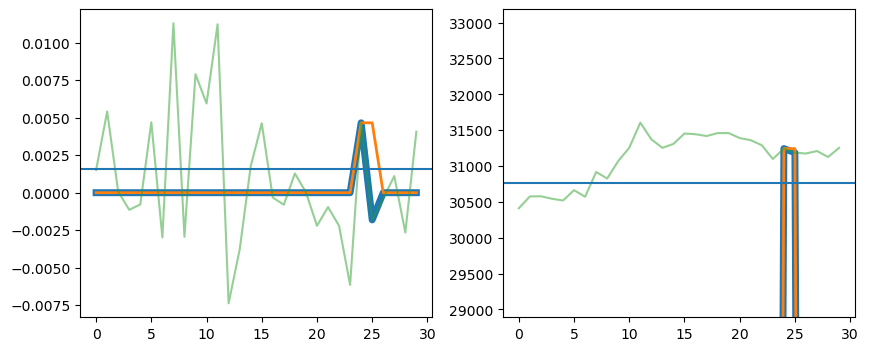

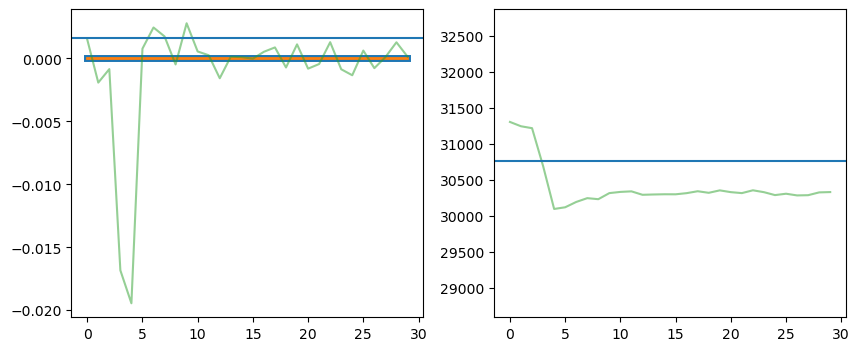

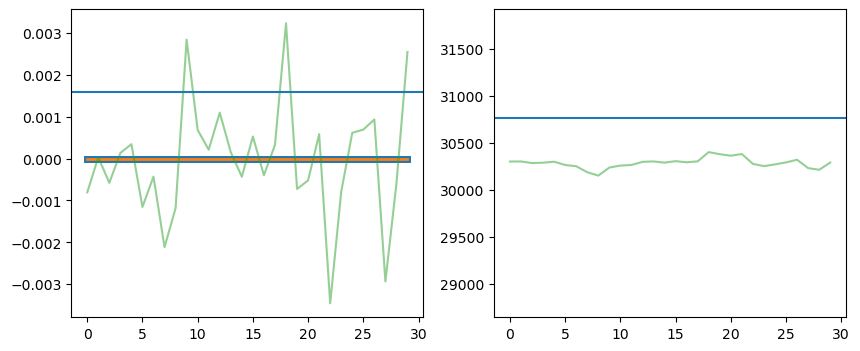

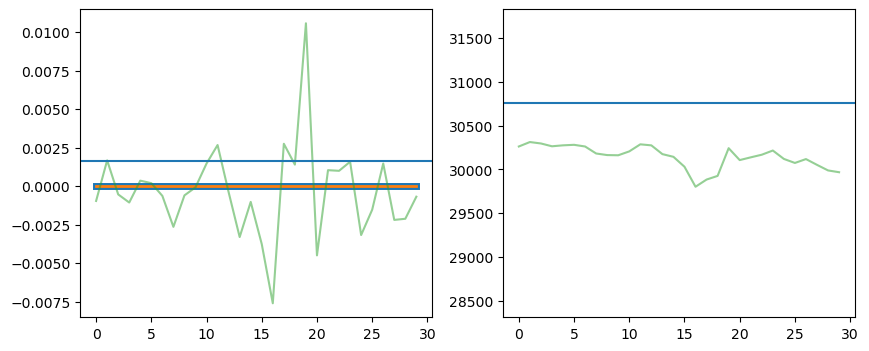

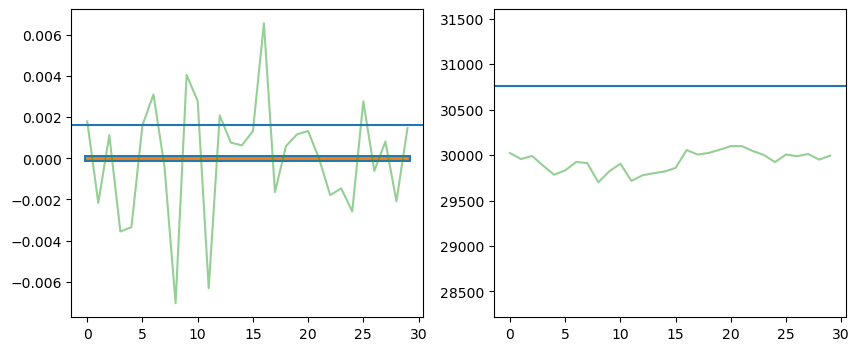

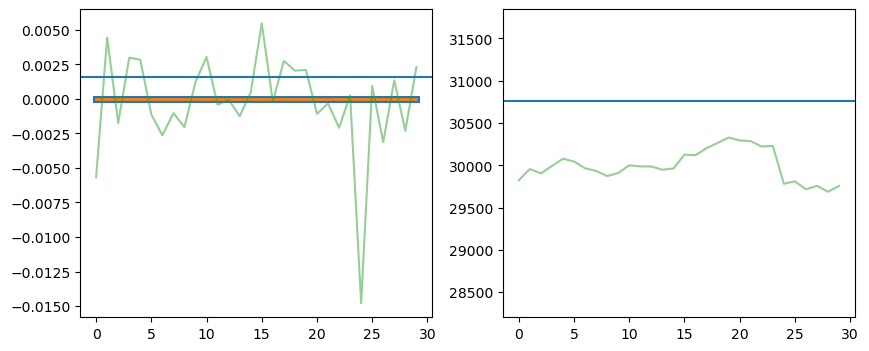

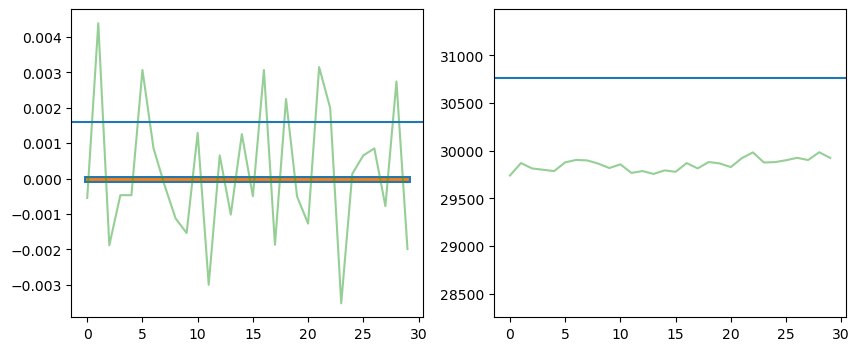

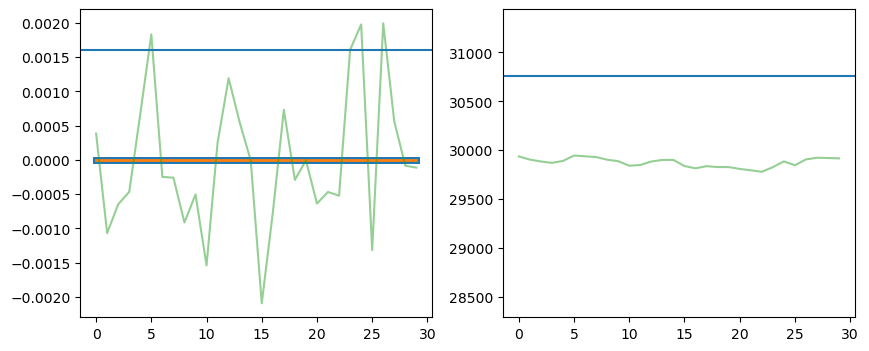

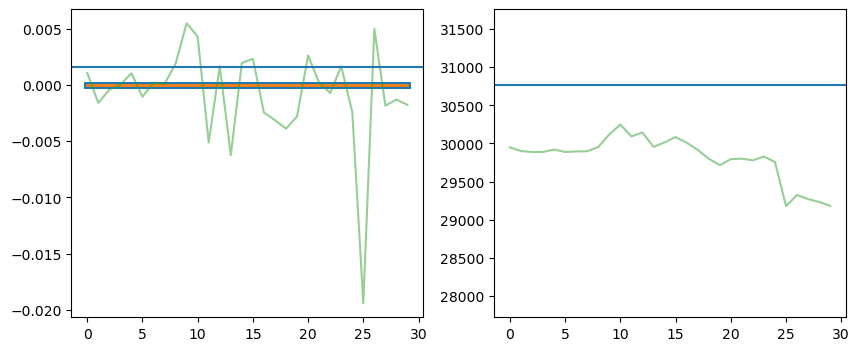

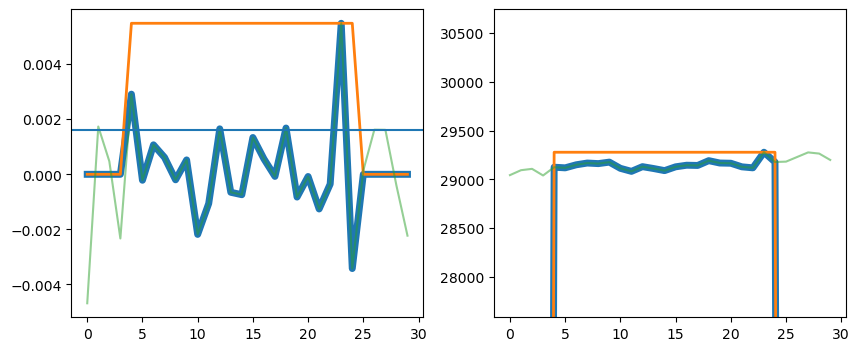

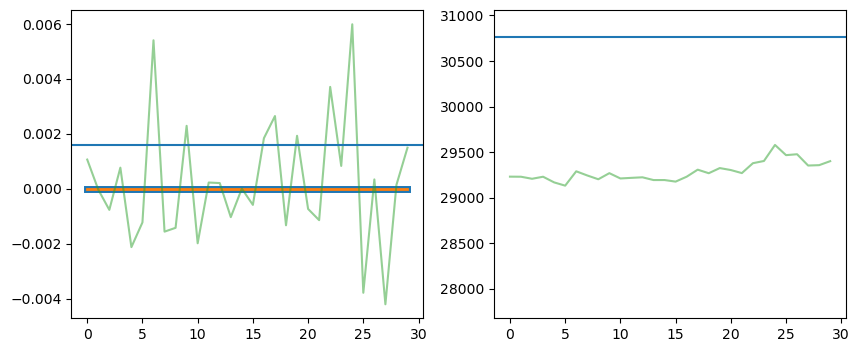

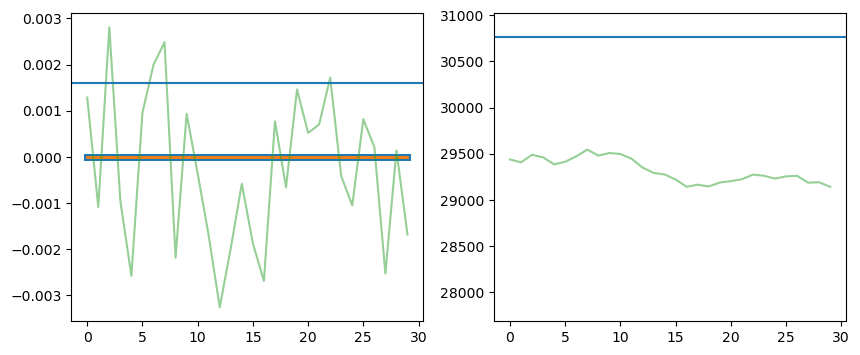

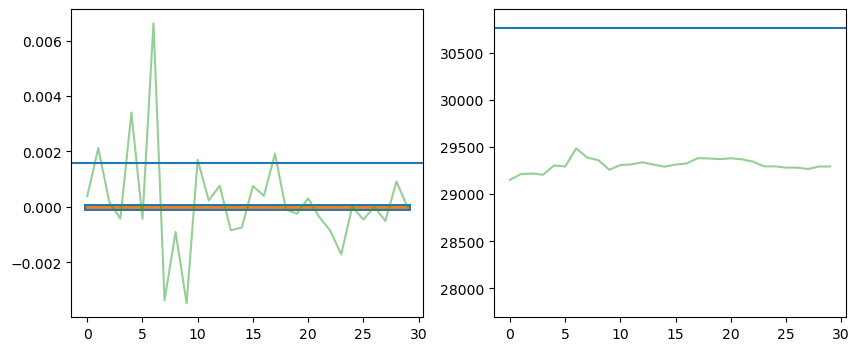

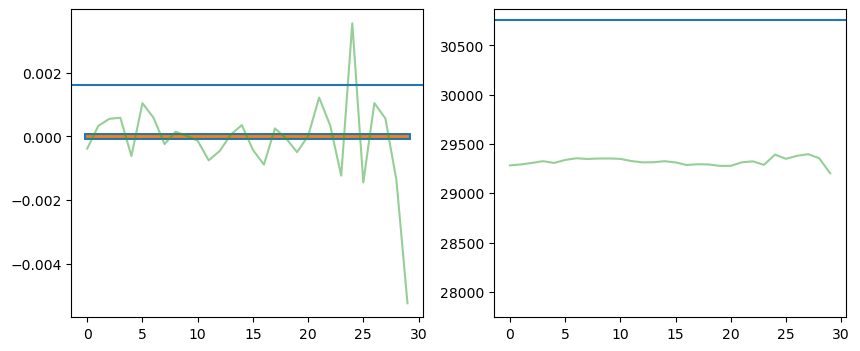

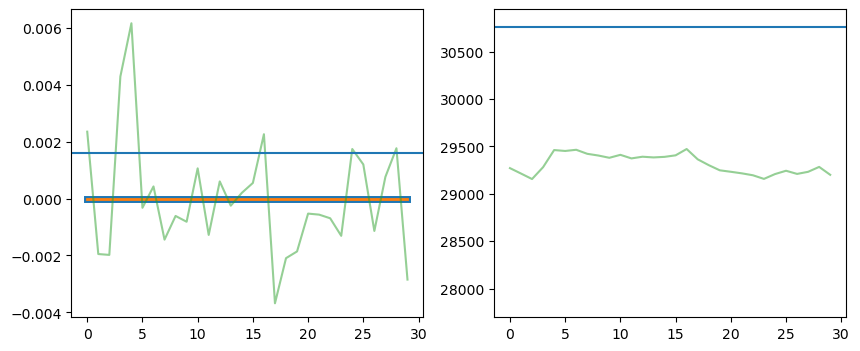

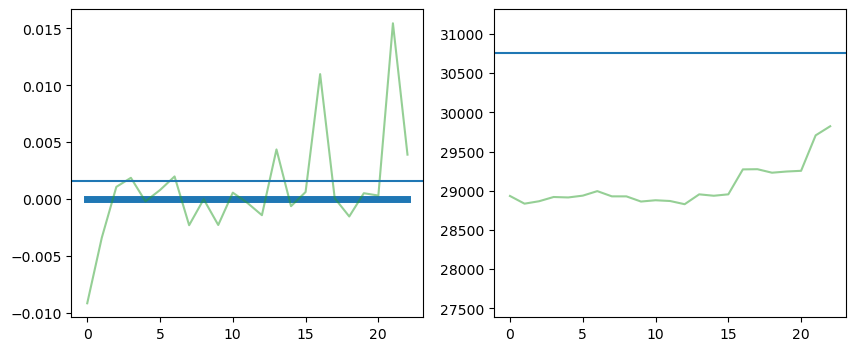

In [530]:
slide=30
strides = np.arange(0,len(x),slide)


for i, stride in enumerate(strides):



    fig, axs = plt.subplots(1,2, figsize=(10,4))

    _sc = (trade_signal*x3)[stride:stride+slide].max()
    axs[0].plot((trade_signal*x3)[stride:stride+slide], lw=5)
    axs[0].plot((_sc)*(trade_signal)[stride:stride+slide], lw=2)
    axs[0].plot(x3[stride:stride+slide], alpha =0.5)
    # axs[0].ylim(29000)

    axs[0].axhline(y=cutoff)

    _sc = (trade_signal*x2)[stride:stride+slide].max()
    axs[1].plot((trade_signal*x2)[stride:stride+slide], lw=5)
    axs[1].plot((_sc)*(trade_signal)[stride:stride+slide], lw=2)
    axs[1].plot(x2[stride:stride+slide], alpha =0.5)
    axs[1].set_ylim(np.nanmin(x2[stride:stride+slide]) * 0.95)

    axs[1].axhline(y=cutoff2)


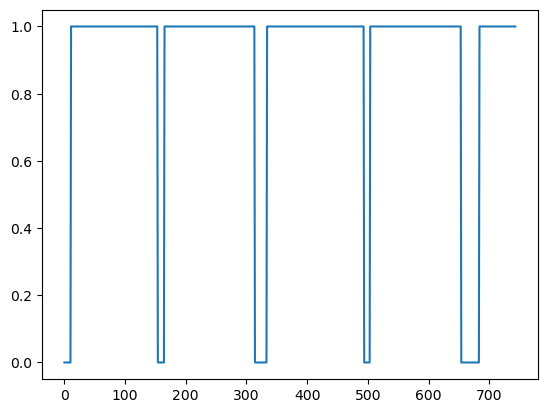

In [516]:

def reconstruct_second_array(first_array: np.ndarray, N: int) -> np.ndarray:
    length = len(first_array)
    block_size = length // N
    remainder = length % N

    second_array = np.zeros_like(first_array)

    start = 0
    for i in range(N):
        end = start + block_size + (1 if i < remainder else 0)
        block = first_array[start:end]
        if np.any(block == 1):
            second_array[start:end] = 1
        start = end

    return second_array

t = np.where(x>cutoff)[0]

tar = np.zeros_like(x)
tar[t] = 1


first = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
tar2 = reconstruct_second_array(tar, N)


plt.plot(tar2)
# plt.plot( np.nanmax(x) * tar2 * x)

# plt.plot(x)

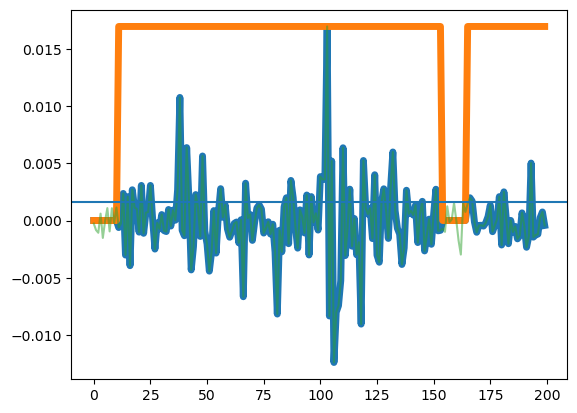

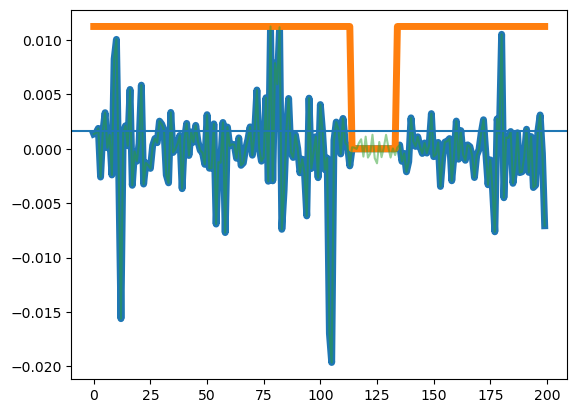

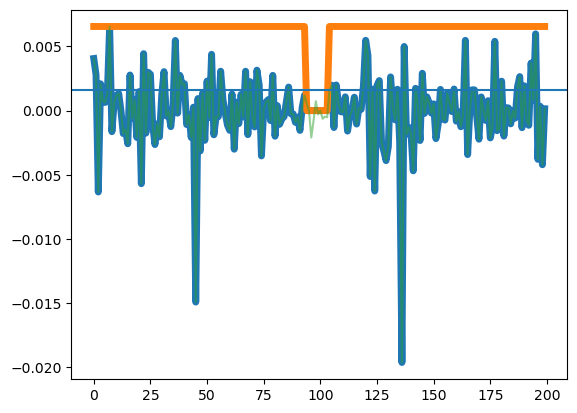

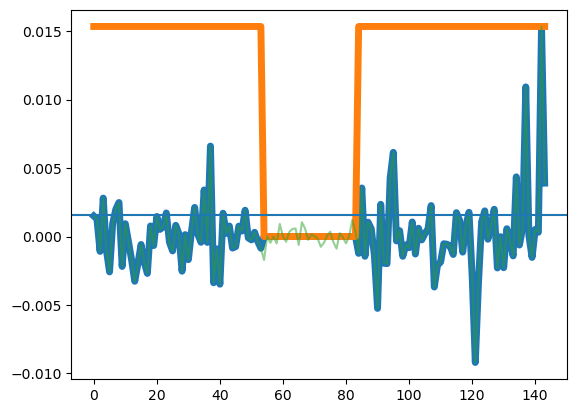

In [517]:
strides = np.arange(0,744,200)


for i, stride in enumerate(strides):

    plt.plot((tar2*x)[stride:stride+200], lw=5)

    _sc = (tar2*x)[stride:stride+200].max()
    plt.plot((_sc)*(tar2)[stride:stride+200], lw=5)
    plt.plot(x[stride:stride+200], alpha =0.5)

    plt.axhline(y=cutoff)
    plt.show()

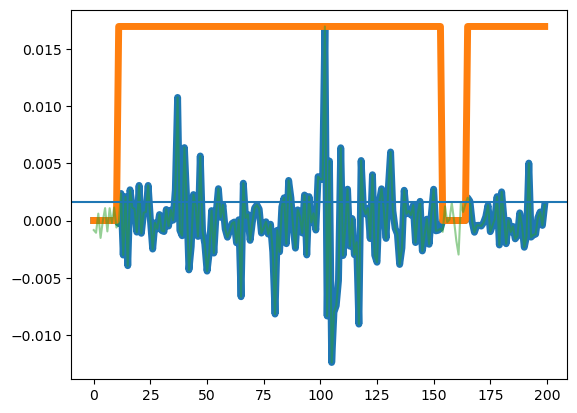

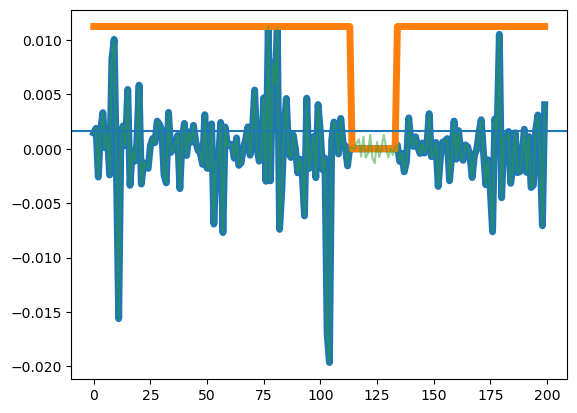

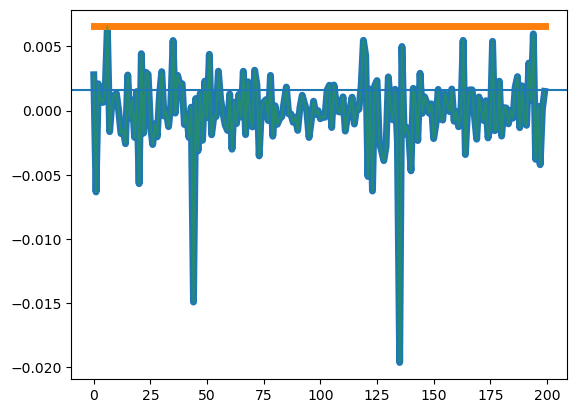

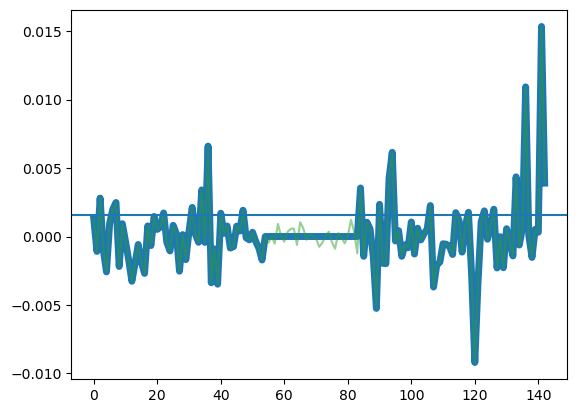

In [498]:
strides = np.arange(0,744,200)


for i, stride in enumerate(strides):

    plt.plot((tar2*x)[stride:stride+200], lw=5)

    _sc = (tar2*x)[stride:stride+200].max()
    plt.plot((_sc)*(tar2)[stride:stride+200], lw=5)
    plt.plot(x[stride:stride+200], alpha =0.5)

    plt.axhline(y=cutoff)
    plt.show()


In [141]:
import torch
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

v = utils.get_features_matrix(df)
v = v.values


m = fm["pca"].transform(v)

m = torch.tensor(m, dtype=torch.float32)
fm["regressor"].eval()
with torch.no_grad():
    preds = torch.sigmoid(fm["regressor"](m))



plt.plot()


/home/mdm/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


RuntimeError: input.size(-1) must be equal to input_size. Expected 1, got 2

In [246]:
import monte_carlo_wf
mreload(monte_carlo_wf)

sam = monte_carlo_wf.run_mc(df, train_period=train_period, test_period=test_period, N=N, n_samples=3)

# plt.plot(np.cumsum(df["log_ret"]))
# plt.plot(np.cumsum(sam["log_ret"]))

/home/mdm/coding/fintech/model_dev/learn/monte_carlo_wf.py:99: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  
/home/mdm/coding/fintech/model_dev/learn/monte_carlo_wf.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/mdm/coding/fintech/model_dev/learn/utils.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"r

tensor([8.9951], dtype=torch.float64)
Epoch 0, Loss: 1.2576
Epoch 100, Loss: 1.1760


ValueError: Target size (torch.Size([620, 1])) must be the same as input size (torch.Size([596, 1]))

In [224]:
# import monte_carlo_wf
# mreload(monte_carlo_wf)

# sim_return, profit_ratios, sharpe_ratios = monte_carlo_wf.run_mc(df, train_period=train_period, test_period=test_period, N=N, n_samples=30)

In [191]:
sharpe_ratios

[0.015355776918511805]

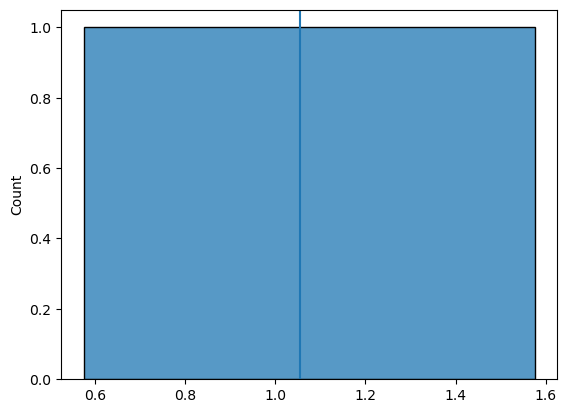

In [187]:
sns.histplot(profit_ratios)
plt.axvline(x=pr)

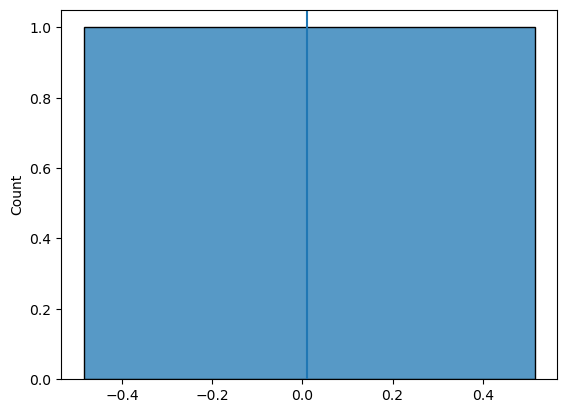

In [188]:
sns.histplot(sharpe_ratios)
plt.axvline(x=sharpe)

In [192]:
sharpe

0.011121328802551032

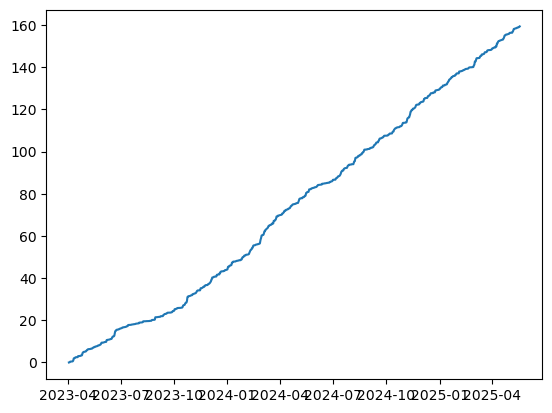

In [256]:
plt.plot(np.cumsum(log_return[profitable]))

In [152]:
model.eval()
with torch.no_grad():
    preds = model(X_tensor)    

preds.unsqueeze(-1) 

tensor([[[0.4459]],

        [[0.4051]],

        [[0.3468]],

        ...,

        [[0.5724]],

        [[0.5635]],

        [[0.5409]]])